In [43]:
import numpy as np
import numpy_financial as npf
import pandas as pd
import csv
import json
import matplotlib.pyplot as plt
import category_encoders as ce 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_predict

import tensorflow as tf
import seaborn as sns
from distfit import distfit
import scipy
from scipy.stats import norm

import random
import keras
from keras.models import Sequential
from keras.layers import Dense
import statsmodels.formula.api as sm



## Collect data

In [44]:
def read_pitchbook_json(file_number):
    with open('d{}.json'.format(file_number), encoding='iso-8859-1') as json_file:
        data = json.load(json_file)
    
    entity_id = [row['entityId'] for row in data['dataRows']]
    pb_id = [row['pbId'] for row in data['dataRows']]
    post_valuation = [row['columnValues']['postValuation'][0]['amount'] if row['columnValues']['postValuation'] else 'NaN' for row in data['dataRows']]
    company_name = [row['columnValues']['companyName'][0]['name'] if row['columnValues']['companyName'] else 'NaN' for row in data['dataRows']]
    deal_size = [row['columnValues']['dealSize'][0]['amount'] if row['columnValues']['dealSize'] else '' for row in data['dataRows']]
    deal_type = [row['columnValues']['dealType2'][0]['value'] if row['columnValues']['dealType2'] else '' for row in data['dataRows']]
    industry = [row['columnValues']['primaryIndustryCode'][0]['value'] if row['columnValues']['primaryIndustryCode'] else '' for row in data['dataRows']]
    investors = [', '.join([i['name'] for i in row['columnValues']['investors']]) if 'investors' in row['columnValues'] else '' for row in data['dataRows']]
    deal_date = [row['columnValues']['dealDate'][0]['asOfdate'] if row['columnValues']['dealDate'] else '' for row in data['dataRows']]

    df = pd.DataFrame({'entity_id':entity_id,
                   'pb_id':pb_id,
                   'post_valuation':post_valuation,
                   'company_name':company_name,
                   'deal_size':deal_size,
                   'deal_type': deal_type,
                   'industry':industry,
                   'investors':investors,
                   'deal_date':deal_date})
    return df

In [45]:
df = read_pitchbook_json(1)
for i in range(1,68):
    dfi = read_pitchbook_json(i)
    df = pd.concat([df, dfi], ignore_index=True)
df.shape

(16817, 9)

In [46]:
df.head()

,entity_id,pb_id,post_valuation,company_name,deal_size,deal_type,industry,investors,deal_date
0,1953610,185824-90T,15.0,Aigen,4.00,Series 1,Business/Productivity Software,"AgFunder, Global Founders Capital, New Enterpr...",2021-12-30
1,1978865,188097-85T,280.5,AQUIS,30.50,Series C1,Personal Products,"Anette Nordvall, Exaltare Capital Partners, VM...",2021-12-30
2,2220643,209857-87T,70.42,Arcadier,3.62,,Software Development Applications,,2021-12-30
3,1954539,185908-51T,121.81,Bond Biosciences,6.81,Series B,Drug Discovery,"BioGenerator, Collage Venture Partners, Transh...",2021-12-30
4,2223260,210093-40T,267.97,Capillary Technologies,28.03,Series E,Business/Productivity Software,,2021-12-30


In [47]:
def read_pitchbook_exit_json(file_number):
    with open('e{}.json'.format(file_number), encoding='iso-8859-1') as json_file:
        data = json.load(json_file)
    
    entity_id = [row['entityId'] for row in data['dataRows']]
    pb_id = [row['pbId'] for row in data['dataRows']]
    post_valuation = [row['columnValues']['postValuation'][0]['amount'] if row['columnValues']['postValuation'] else 'NaN' for row in data['dataRows']]
    company_name = [row['columnValues']['companyName'][0]['name'] if row['columnValues']['companyName'] else 'NaN' for row in data['dataRows']]
    deal_size = [row['columnValues']['dealSize'][0]['amount'] if row['columnValues']['dealSize'] else '' for row in data['dataRows']]
    deal_type = [row['columnValues']['dealType'][0]['value'] if row['columnValues']['dealType'] else '' for row in data['dataRows']]
    industry = [row['columnValues']['primaryIndustryCode'][0]['value'] if row['columnValues']['primaryIndustryCode'] else '' for row in data['dataRows']]
    investors = [', '.join([i['name'] for i in row['columnValues']['investors']]) if 'investors' in row['columnValues'] else '' for row in data['dataRows']]
    deal_date = [row['columnValues']['dealDate'][0]['asOfdate'] if row['columnValues']['dealDate'] else '' for row in data['dataRows']]

    df = pd.DataFrame({'entity_id':entity_id,
                   'pb_id':pb_id,
                   'post_valuation':post_valuation,
                   'company_name':company_name,
                   'deal_size':deal_size,
                   'deal_type': deal_type,
                   'industry':industry,
                   'investors':investors,
                   'deal_date':deal_date})
    return df

In [48]:
df_exit = read_pitchbook_exit_json(1)
for i in range(1,26):
    df_exit_i = read_pitchbook_exit_json(i)
    df_exit = pd.concat([df_exit, df_exit_i], ignore_index=True)

In [49]:
def read_pitchbook_companyinfo_json(file_number):
    with open('../backed_up_company_info/p{}.json'.format(file_number), encoding='iso-8859-1') as json_file:                                                            
        data = json.load(json_file)
    
    entity_id = [row['entityId'] for row in data['dataRows']]
    pb_id = [row['pbId'] for row in data['dataRows']]
    company_name = [row['columnValues']['companyName'][0]['name'] if row['columnValues']['companyName'] else 'NaN' for row in data['dataRows']]
    year_founded = [row['columnValues']['yearFounded'][0]['value'] if row['columnValues']['yearFounded'] else 'NaN' for row in data['dataRows']]
    ownership_status = [row['columnValues']['ownershipStatus'][0]['value'] if row['columnValues']['ownershipStatus'] else '' for row in data['dataRows']]
    business_status = [row['columnValues']['businessStatus'][0]['value'] if row['columnValues']['businessStatus'] else '' for row in data['dataRows']]
    industry = [row['columnValues']['primaryIndustryCode'][0]['value'] if row['columnValues']['primaryIndustryCode'] else '' for row in data['dataRows']]
    investors = [', '.join([i['value'] for i in row['columnValues']['activeInvestors']]) if 'investors' in row['columnValues'] else '' for row in data['dataRows']]
    total_raised = [row['columnValues']['vcRaised'][0]['value'] if row['columnValues']['vcRaised'] else '' for row in data['dataRows']]
    last_known_valuation_deal_type = [row['columnValues']['lastKnownValuationDealType'][0]['value'] if row['columnValues']['lastKnownValuationDealType'] else '' for row in data['dataRows']]
    last_known_valuation = [row['columnValues']['lastKnownValuation'][0]['amount'] if row['columnValues']['lastKnownValuation'] else '' for row in data['dataRows']]
    last_known_valuation_date = [row['columnValues']['lastKnownValuation'][0]['asOfDate'] if row['columnValues']['lastKnownValuation'] else '' for row in data['dataRows']]
    last_known_financing_amount = [row['columnValues']['lastFinancingSize'][0]['amount'] if row['columnValues']['lastFinancingSize'] else '' for row in data['dataRows']]
    last_known_financing_date = [row['columnValues']['lastFinancingSize'][0]['asOfDate'] if row['columnValues']['lastFinancingSize'] else '' for row in data['dataRows']]
    df_cpinfo = pd.DataFrame({'entity_id':entity_id,
                   'pb_id':pb_id,
                   'company_name':company_name,
                   'year_founded':year_founded,
                   'ownership_status':ownership_status,
                   'business_status': business_status,
                   'industry':industry,
                   'investors':investors,
                   'total_raised':total_raised,
                   'last_known_valuation_deal_type': last_known_valuation_deal_type,
                   'last_known_valuation': last_known_valuation,
                   'last_known_valuation_date': last_known_valuation_date,
                   'last_known_financing_amount': last_known_financing_amount,
                   'last_known_financing_date': last_known_financing_date
                   })
    return df_cpinfo

In [50]:
df_cpinfo = read_pitchbook_companyinfo_json(1)
for i in range(1,35):
    dfi = read_pitchbook_companyinfo_json(i)
    df_cpinfo = pd.concat([df_cpinfo, dfi], ignore_index=True)
df_cpinfo.shape

(8750, 14)

In [51]:
df_cpinfo.drop_duplicates(inplace=True)

In [52]:
df_cpinfo.shape

(8500, 14)

## Processing data

### preprocessing three df from Pitchbook Json

#### first two df

In [53]:
def data_preprocess(Deal_df):
    Deal_df['deal_date'] = pd.to_datetime(Deal_df['deal_date'])
    Deal_df['post_valuation'] = pd.to_numeric(Deal_df['post_valuation'],errors='coerce')
    indexnottarget= Deal_df[(Deal_df['deal_type'] == 'Public Investment 2nd Offering') | (Deal_df['deal_type'] == 'Dividend') | (Deal_df['deal_type'] == 'Share Repurchase')].index
    Deal_df.drop(indexnottarget , inplace=True)
    Deal_df.index =  range(len(Deal_df.index))
    return Deal_df

In [54]:
df_withtypelabel = data_preprocess(df)
df_withtypelabel['deal_type_code'] = np.zeros(df_withtypelabel.shape[0],dtype=np.int32)
df_exit_withtypelabel = data_preprocess(df_exit)
df_exit_withtypelabel['deal_type_code'] = np.where(df_exit_withtypelabel['deal_type']!= 'IPO', 1, 2)
# df_exit_withtypelabel['deal_type_code'] = np.ones(df_exit_withtypelabel.shape[0],dtype=np.int32)

#### df from company page

In [56]:
select_rows = ['entity_id','pb_id','company_name','last_known_valuation','investors','last_known_valuation_deal_type','industry','last_known_valuation_date']
select_exit_type = ['Merger/Acquisition', 'IPO']
success_exit_condition = df_cpinfo['last_known_valuation_deal_type'].isin(select_exit_type)
success_exit_deal_extra = df_cpinfo.loc[success_exit_condition, select_rows]
column_name_mapping = {
    'last_known_valuation': 'post_valuation',
    'last_known_valuation_deal_type': 'deal_type',
    'last_known_valuation_date': 'deal_date',
}

# Use the rename() method to change the column names
success_exit_deal_extra.rename(columns=column_name_mapping, inplace=True)
success_exit_deal_extra['deal_date'] = pd.to_datetime(success_exit_deal_extra['deal_date'])
success_exit_deal_extra['post_valuation'] = pd.to_numeric(success_exit_deal_extra['post_valuation'],errors='coerce')
success_exit_deal_extra.index =  range(len(success_exit_deal_extra.index))
success_exit_deal_extra['deal_type_code'] = np.where(success_exit_deal_extra['deal_type']!= 'IPO', 1, 2)
success_exit_deal_extra['deal_size'] = success_exit_deal_extra['post_valuation']*0.4


In [57]:
success_exit_deal_extra.head()

,entity_id,pb_id,company_name,post_valuation,investors,deal_type,industry,deal_date,deal_type_code,deal_size
0,559090,60318-10,10x Genomics (NAS: TXG),3660.14,,IPO,Biotechnology,2019-09-12,2,1464.056
1,485153,53663-77,170 Systems,32.90,,Merger/Acquisition,Business/Productivity Software,2009-09-07,1,13.160
2,481452,53330-68,1stdibs (NAS: DIBS),731.92,,IPO,Specialty Retail,2021-06-10,2,292.768
3,365793,42921-37,2U (NAS: TWOU),1000.00,,Merger/Acquisition,Educational Software,2022-09-27,1,400.000
4,35686,13211-74,2Wire,448.98,,Merger/Acquisition,Telecommunications Service Providers,2010-10-20,1,179.592


In [58]:
drop_colum = ['entity_id','investors','pb_id']
merged_df_exit = (success_exit_deal_extra.drop(columns= drop_colum)).merge(df_exit_withtypelabel.drop(columns=drop_colum), on=['company_name', 'post_valuation', 'deal_type', 'industry',  'deal_date','deal_type_code'], how='outer')

In [59]:
# Sort the DataFrame based on the "company_name" column
merged_df_exit = merged_df_exit.sort_values(by='company_name')

# Reset the index to reflect the new order
merged_df_exit = merged_df_exit.reset_index(drop=True)
merged_df_exit['deal_size'] = merged_df_exit['deal_size_y'].fillna(merged_df_exit['deal_size_x'])

# Drop the 'deal_size_x' and 'deal_size_y' columns, if needed
merged_df_exit.drop(columns=['deal_size_x', 'deal_size_y'], inplace=True)
merged_df_exit

,company_name,post_valuation,deal_type,industry,deal_date,deal_type_code,deal_size
0,10X Capital Venture Acquisition,218.75,IPO,Special Purpose Acquisition Company (SPAC),2020-11-24,2,175.00
1,10X Capital Venture Acquisition II (NAS: VCXA),273.22,IPO,Special Purpose Acquisition Company (SPAC),2021-08-11,2,200.00
2,10x Genomics (NAS: TXG),3660.14,IPO,Biotechnology,2019-09-12,2,390.00
3,1347 Capital,41.80,IPO,Special Purpose Acquisition Company (SPAC),2014-07-16,2,40.00
4,170 Systems,32.90,Merger/Acquisition,Business/Productivity Software,2009-09-07,1,13.16
...,...,...,...,...,...,...,...
7214,sMedio (TKS: 3913),36.17,IPO,Entertainment Software,2015-03-27,2,9.05
7215,superDimension,300.00,Merger/Acquisition,Diagnostic Equipment,2012-05-15,1,120.00
7216,uCloudlink Group (NAS: UCL),5067.93,IPO,Wireless Communications Equipment,2020-06-10,2,36.18
7217,uniQure (NAS: QURE),299.11,IPO,Holding Companies,2014-02-05,2,91.80


### Summary deals by company as df

#### SORT by companies exit or not type

In [60]:
drop_colum = ['entity_id','investors','pb_id']
df_withtypelabel_dropcol = df_withtypelabel.drop(columns=drop_colum)
df_deals = pd.concat([df_withtypelabel_dropcol,merged_df_exit], ignore_index=True)
df_deals.sort_values(by=['company_name','deal_date'],inplace=True)
df_deals.index =  range(len(df_deals.index))
df_deals.head(10)

,post_valuation,company_name,deal_size,deal_type,industry,deal_date,deal_type_code
0,116.63,.tel,69.85,,IT Consulting and Outsourcing,2008-07-23,0
1,172.23,.tel,22.03,,IT Consulting and Outsourcing,2010-06-08,0
2,218.75,10X Capital Venture Acquisition,175.00,IPO,Special Purpose Acquisition Company (SPAC),2020-11-24,2
3,273.22,10X Capital Venture Acquisition II (NAS: VCXA),200.00,IPO,Special Purpose Acquisition Company (SPAC),2021-08-11,2
4,400.00,10x Genomics (NAS: TXG),75.00,Series C,Biotechnology,2016-03-17,0
5,3660.14,10x Genomics (NAS: TXG),390.00,IPO,Biotechnology,2019-09-12,2
6,30.20,12twenty,6.05,Series A1,Human Capital Services,2015-06-02,0
7,41.80,1347 Capital,40.00,IPO,Special Purpose Acquisition Company (SPAC),2014-07-16,2
8,122.50,1366 Technologies,22.50,Series C,Application Specific Semiconductors,2015-03-24,0
9,170.00,1366 Technologies,47.50,Series C,Application Specific Semiconductors,2016-06-28,0


In [61]:
def data_select_ROF_exit_test(Deal_Refine):
    
    type_label = np.array([])
    grouped_comp = Deal_Refine.groupby('company_name')

    for name, group in grouped_comp:
        if 0 not in group['deal_type_code'].values:
            # if (1 or 2) in group['deal_type_code'].values:
            label = 'Only_Exit'
        else:
            idex_0 = group['deal_type_code'].to_list().index(0)
            if 1 in group.loc[idex_0:,'deal_type_code'].values:
                label = 'RoF_MA'

                idex_1 = group.loc[idex_0:,'deal_type_code'].to_list().index(1)

                drop_idx1 = group.index.tolist()[:idex_0] + group.index.tolist()[idex_1+1:]
                group.drop(index=drop_idx1, inplace = True)
                Deal_Refine.drop(index=drop_idx1, inplace = True)
            elif 2 in group.loc[idex_0:,'deal_type_code'].values:
                label = 'RoF_IPO'

                idex_2 = group.loc[idex_0:,'deal_type_code'].to_list().index(2)

                drop_idx2 = group.index.tolist()[:idex_0] + group.index.tolist()[idex_2+1:]
                group.drop(index=drop_idx2, inplace = True)
                Deal_Refine.drop(index=drop_idx2, inplace = True)
            else:
                label = 'Only_RoF'
        type_label = np.append(type_label,np.repeat(label,group.shape[0]))

    Deal_Refine.index =  range(len(Deal_Refine.index))
    Deal_Refine['Company_tran_type'] = pd.Series(type_label)
        
    
    return Deal_Refine

#### Sort companies by type results

In [62]:
df_deals_refine = data_select_ROF_exit_test(df_deals)
df_deals_refine.head(10)

,post_valuation,company_name,deal_size,deal_type,industry,deal_date,deal_type_code,Company_tran_type
0,116.63,.tel,69.85,,IT Consulting and Outsourcing,2008-07-23,0,Only_RoF
1,172.23,.tel,22.03,,IT Consulting and Outsourcing,2010-06-08,0,Only_RoF
2,218.75,10X Capital Venture Acquisition,175.00,IPO,Special Purpose Acquisition Company (SPAC),2020-11-24,2,Only_Exit
3,273.22,10X Capital Venture Acquisition II (NAS: VCXA),200.00,IPO,Special Purpose Acquisition Company (SPAC),2021-08-11,2,Only_Exit
4,400.00,10x Genomics (NAS: TXG),75.00,Series C,Biotechnology,2016-03-17,0,RoF_IPO
5,3660.14,10x Genomics (NAS: TXG),390.00,IPO,Biotechnology,2019-09-12,2,RoF_IPO
6,30.20,12twenty,6.05,Series A1,Human Capital Services,2015-06-02,0,Only_RoF
7,41.80,1347 Capital,40.00,IPO,Special Purpose Acquisition Company (SPAC),2014-07-16,2,Only_Exit
8,122.50,1366 Technologies,22.50,Series C,Application Specific Semiconductors,2015-03-24,0,Only_RoF
9,170.00,1366 Technologies,47.50,Series C,Application Specific Semiconductors,2016-06-28,0,Only_RoF


In [63]:
df_deals_refine.Company_tran_type.value_counts()

Only_RoF     12030
RoF_MA        5184
Only_Exit     4849
RoF_IPO       1909
Name: Company_tran_type, dtype: int64

#### Successful Exit Company Dataset

In [64]:
df_deal_RoFExit = df_deals_refine[(df_deals_refine.Company_tran_type == 'RoF_IPO') | (df_deals_refine.Company_tran_type == 'RoF_MA')].reset_index(drop=True)

In [87]:
df_deal_RoFExit.head()

,post_valuation,company_name,deal_size,deal_type,industry,deal_date,deal_type_code,Company_tran_type
0,400.00,10x Genomics (NAS: TXG),75.00,Series C,Biotechnology,2016-03-17,0,RoF_IPO
1,3660.14,10x Genomics (NAS: TXG),390.00,IPO,Biotechnology,2019-09-12,2,RoF_IPO
2,48.94,170 Systems,13.92,Series A,Business/Productivity Software,2002-04-16,0,RoF_MA
3,32.90,170 Systems,13.16,Merger/Acquisition,Business/Productivity Software,2009-09-07,1,RoF_MA
4,180.00,1stdibs (NAS: DIBS),60.00,Series A,Specialty Retail,2011-11-03,0,RoF_IPO


In [88]:
df_deal_RoFExit.shape[0]

7093

In [66]:
# mutiple rounds
coompany_name_muti_rounds = []
for name, group in df_deal_RoFExit.groupby('company_name'):
    if group.shape[0] > 3:
        coompany_name_muti_rounds.append(name)

In [67]:
df_deal_RoFExit_mutirounds = df_deal_RoFExit[df_deal_RoFExit['company_name'].isin(coompany_name_muti_rounds)]
df_deal_RoFExit_mutirounds.shape

(3788, 8)

#### Find company have rounds on the same date

In [91]:
df_deal_RoFExit_mutirounds.deal_date.dt.strftime('%Y-%m')

4       2011-11
5       2012-09
6       2014-01
7       2015-09
8       2021-06
         ...   
7079    2018-04
7084    2005-09
7085    2008-09
7086    2012-08
7087    2014-12
Name: deal_date, Length: 3788, dtype: object

In [92]:
df_deal_RoFExit_mutirounds['deal_date_M'] = df_deal_RoFExit_mutirounds.deal_date.dt.strftime('%Y-%m')

In [93]:
df_deal_RoFExit_mutirounds['deal_date_M'].value_counts()

2014-04    37
2014-12    37
2014-05    37
2013-12    34
2013-01    34
           ..
2020-03     1
2023-05     1
2022-03     1
2018-03     1
2023-03     1
Name: deal_date_M, Length: 257, dtype: int64

In [94]:
condition = (
    (df_deal_RoFExit_mutirounds['deal_date_M'] == '2014-04') &
    (df_deal_RoFExit_mutirounds['deal_type'].isin(['Series E','Series F','Series G', 'Series H', 'IPO', 'Merger/Acquisition']))
)

# Apply the condition to filter the DataFrame
filtered_deals = df_deal_RoFExit_mutirounds[condition]
filtered_company = filtered_deals.company_name
filtered_df = df_deal_RoFExit_mutirounds[df_deal_RoFExit_mutirounds.company_name.isin(filtered_company.values)]
filtered_df.groupby('company_name')['deal_date_M'].min()

company_name
Adamas Pharmaceuticals               2006-06
Apigee                               2010-02
Chronix Biomedical                   2007-02
Cisco Jasper                         2008-08
Five9 (NAS: FIVN)                    2008-03
Glam                                 2006-12
Grubhub                              2010-11
JasperSoft                           2007-08
LendingClub (NYS: LC)                2010-04
New Relic (NYS: NEWR)                2010-10
Palantir Technologies (NYS: PLTR)    2008-02
Pulmonx (NAS: LUNG)                  2007-05
Pure Storage (NYS: PSTG)             2011-07
ReliOn                               2004-11
Name: deal_date_M, dtype: object

In [95]:
# items_to_remove = ['Grubhub',"New Relic (NYS: NEWR)",'Pure Storage (NYS: PSTG)']
# keep_mask = ~np.isin(filtered_company, items_to_remove)
# portfolio_company = filtered_company[keep_mask]
portfolio_company = filtered_company

### Success Exit company group by company + analyze

#### Creating the by company df

In [68]:
company_name = []
industry = []
start_date = []

initial_firm_value = []
firm_value_list = []
firmvalue_first_increment = []
firmvalue_final_increment = []

investment_amount_list = []
investment_time_list = []
investment_increment_average = []
sum_of_investment = []
investment_rounds_number = []

firm_value_right_before_exit = []

duration = []
exit_value = []
exit_type = []


for company, data in df_deal_RoFExit_mutirounds.groupby('company_name'):

    small_df = pd.DataFrame(data)
    
    # first investment consider as the initial t = 0 
    company_initial_firm_value = small_df.post_valuation.values[0] - small_df.deal_size.values[0]
    company_firm_value_list = small_df.post_valuation.values - small_df.deal_size.values

    # firm investment used to calculate starting amount
    company_investment_array = small_df.deal_size.values[:-1]
    company_investment_sum = small_df.deal_size.values[1:-1].sum()
    # different bewteen rounds from the first round
    timdiff = small_df.deal_date.diff().values[1:]
    timdiff_days = timdiff.astype('timedelta64[D]') / np.timedelta64(1, 'D')
    company_investment_time = np.round(np.cumsum(timdiff_days[:-1])/365).astype(int)
    company_investment_time = np.insert(company_investment_time, 0, 0)

    if small_df.Company_tran_type.values[0] == 'RoF_IPO':
        exit_type.append(0)
    else:
        exit_type.append(1)


    # add elements to list
    company_name.append(company)
    industry.append(small_df.industry.values[0])
    start_date.append(small_df.deal_date.values[0])

    initial_firm_value.append(company_initial_firm_value)
    firm_value_list.append(company_firm_value_list)
    firmvalue_first_increment.append(company_firm_value_list[1] - company_firm_value_list[0])
    firmvalue_final_increment.append(company_firm_value_list[-1] - company_firm_value_list[-2])

    investment_amount_list.append(company_investment_array)
    investment_time_list.append(company_investment_time)
    investment_increment_average.append(small_df.deal_size.diff().values[1:-1].mean())
    sum_of_investment.append(company_investment_sum)
    investment_rounds_number.append(small_df.shape[0]-1)
        
    firm_value_right_before_exit.append(small_df.post_valuation.values[-1] - small_df.deal_size.values[-1])

    duration.append(np.round(np.cumsum(timdiff_days)/365).astype(int)[-1])
    exit_value.append(small_df.post_valuation.values[-1] - small_df.deal_size.values[-1])
    
    
df = pd.DataFrame({ 'company_name':company_name,
                   'industry':industry,
                    'Initial_investment_date':start_date,
                    'initial_firmvalue': initial_firm_value,
                    'Premoney_val_list':firm_value_list,
                    'firmvalue_first_increment':firmvalue_first_increment,
                    'firmvalue_final_increment':firmvalue_final_increment,
                    'investment_amount_list':investment_amount_list,
                    'investment_time_list':investment_time_list,
                    'investment_increment_average':investment_increment_average,
                    'sum_invest_amount':sum_of_investment,
                    'Number_of_round':investment_rounds_number,
                    'Investment_period': np.array(duration),
                    'exit_value': exit_value,
                    'exit_type': exit_type,
                    'payoff_DPI': np.array(exit_value) / np.array(sum_of_investment),
                    'payoff_firmvalue_muti':np.array(exit_value) / np.array(initial_firm_value),
                    })
    




In [69]:
df['start_date_diff_earliest'] = ((df['Initial_investment_date'] - df['Initial_investment_date'].min()).dt.days)/365

In [71]:
df['investment_time_diff'] = df['investment_time_list'].apply(lambda x:np.mean(np.diff(x)))

In [70]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['industry_encoded'] = le.fit_transform(df['industry'])

In [72]:
df.head()

,company_name,industry,Initial_investment_date,initial_firmvalue,Premoney_val_list,firmvalue_first_increment,firmvalue_final_increment,investment_amount_list,investment_time_list,investment_increment_average,sum_invest_amount,Number_of_round,Investment_period,exit_value,exit_type,payoff_DPI,payoff_firmvalue_muti,start_date_diff_earliest,industry_encoded,investment_time_diff
0,1stdibs (NAS: DIBS),Specialty Retail,2011-11-03,120.00,"[120.0, 255.0, 370.0, 342.0, 616.92]",135.00,274.920,"[60.0, 42.05, 15.0, 55.0]","[0, 1, 2, 4]",-1.666667,112.05,4,10,616.920,0,5.505756,5.141000,9.816438,96,1.333333
1,23andMe (NAS: ME),Laboratory Services (Healthcare),2011-01-06,148.00,"[148.0, 230.8, 980.0, 1700.0, 3476.0]",82.80,1776.000,"[31.0, 57.95, 115.0, 250.0]","[0, 2, 5, 7]",73.000000,422.95,4,10,3476.000,1,8.218466,23.486486,8.991781,53,2.333333
2,2U (NAS: TWOU),Educational Software,2011-02-01,186.47,"[186.47, 247.79999999999998, 389.4099999999999...",61.33,210.590,"[32.52, 31.1, 119.28]","[0, 3, 3]",43.380000,150.38,3,12,600.000,1,3.989892,3.217676,9.063014,34,1.500000
3,3VR,Business/Productivity Software,2006-10-09,75.00,"[75.0, 30.0, 113.0, 3.726]",-45.00,-109.274,"[15.0, 12.0, 17.0]","[0, 3, 4]",1.000000,29.00,3,11,3.726,1,0.128483,0.049680,4.745205,17,2.000000
4,41st Parameter,IT Consulting and Outsourcing,2007-08-07,45.85,"[45.85, 56.72, 74.77000000000001, 194.4]",10.87,119.630,"[10.07, 3.79, 13.07]","[0, 2, 5]",1.500000,16.86,3,6,194.400,1,11.530249,4.239913,5.572603,48,2.500000


In [101]:
df.describe()

,initial_firmvalue,firmvalue_first_increment,firmvalue_final_increment,investment_increment_average,sum_invest_amount,Number_of_round,Investment_period,exit_value,exit_type,payoff_DPI,payoff_firmvalue_muti,start_date_diff_earliest,investment_time_diff,industry_encoded
count,756.000000,756.000000,755.000000,756.000000,756.000000,756.000000,756.000000,755.000000,756.000000,755.000000,755.000000,756.000000,756.000000,756.000000
mean,110.187619,127.243624,604.406403,19.815017,176.602606,4.010582,8.207672,1443.279634,0.681217,8.646237,48.983377,6.809709,1.650801,49.666667
std,597.805795,802.831681,3461.062985,98.557563,661.975462,1.330197,3.675657,5807.528546,0.466313,25.985113,591.403347,3.757043,0.751434,30.949179
min,-1.000000,-4981.000000,-12760.000000,-58.933333,0.730000,3.000000,1.000000,0.060000,0.000000,0.000622,-276.960000,0.000000,0.250000,0.000000
25%,17.722500,8.177500,-61.255000,-0.218750,31.272500,3.000000,5.000000,49.100000,0.000000,1.098628,1.495338,3.841096,1.000000,19.000000
50%,40.015000,28.550000,22.510000,5.122500,74.430000,4.000000,8.000000,186.000000,1.000000,3.226759,5.034276,6.826027,1.500000,43.000000
75%,82.842500,84.470000,256.170000,16.666667,135.512500,5.000000,10.000000,707.610000,1.000000,7.547829,16.153322,9.761644,2.000000,76.000000
max,14985.000000,13553.600000,49880.000000,2401.133333,11588.720000,12.000000,20.000000,67613.490000,1.000000,434.064081,15882.352941,14.917808,5.000000,103.000000


#### delete extreme deals

In [73]:
# delete extreme companies
df_extreme_companyname = df[ (df['initial_firmvalue'] >= 4000) | (df['payoff_firmvalue_muti']<= 0.1) | (df['payoff_firmvalue_muti'] >= 500) | (df['investment_increment_average'] <= -1000)| (df['payoff_firmvalue_muti']<= 0.1) | (df['payoff_firmvalue_muti'] >= 1000) ]['company_name'].values
len(df_extreme_companyname)

45

In [74]:
df_delete_extreme = df[~df['company_name'].isin(df_extreme_companyname)]
df_delete_extreme.index = range(len(df_delete_extreme.index))

In [75]:
df_delete_extreme.describe()

,initial_firmvalue,firmvalue_first_increment,firmvalue_final_increment,investment_increment_average,sum_invest_amount,Number_of_round,Investment_period,exit_value,exit_type,payoff_DPI,payoff_firmvalue_muti,start_date_diff_earliest,industry_encoded,investment_time_diff
count,711.000000,711.000000,710.000000,711.000000,711.00000,711.000000,711.000000,710.000000,711.000000,710.000000,710.000000,711.000000,711.000000,711.000000
mean,91.069030,140.432321,589.057417,20.378018,174.53692,4.011252,8.175809,1349.879332,0.668073,8.531082,19.798433,6.867692,49.430380,1.650055
std,259.423536,804.481127,3460.263711,101.259496,670.37266,1.328936,3.636479,5363.984449,0.471236,24.741275,45.183818,3.778231,30.967414,0.745125
min,1.070000,-473.990000,-12760.000000,-58.933333,0.73000,3.000000,1.000000,0.654000,0.000000,0.009972,0.100209,0.000000,0.000000,0.250000
25%,17.700000,8.505000,-49.120500,-0.032500,32.68000,3.000000,5.000000,60.000000,0.000000,1.322121,1.934046,3.876712,19.000000,1.000000
50%,39.800000,29.370000,28.793000,5.490000,75.00000,4.000000,8.000000,206.010000,1.000000,3.369532,5.555016,6.972603,43.000000,1.500000
75%,82.875000,86.130000,267.745000,16.812500,136.12500,5.000000,10.000000,727.522500,1.000000,7.699015,17.085627,9.841096,76.000000,2.000000
max,3784.000000,13553.600000,49880.000000,2401.133333,11588.72000,12.000000,20.000000,67613.490000,1.000000,434.064081,481.839080,14.917808,103.000000,5.000000


## Model Result 

### The growthrate sample

In [ ]:
# revised 10.28
class selection_one_company_knowndata():
    def __init__(self, K=100, growth_rate= 3, invest_jump = 1,decrease_jump = 0, investment_amount=[30,40,50], investment_round=[1,3,4], inital_firm_value=150, Max_investment_length= 20, Expacted_net_pro_ratio=10, muti=3):
        self.K = K #number of iteration
        self.growth_rate = growth_rate
        self.invest_jump = invest_jump
        self.decrease_jump = decrease_jump
        self.inital_firm_value = inital_firm_value
        self.investment_round = investment_round
        self.investment_amount = investment_amount
        self.Max_investment_length = Max_investment_length 
        self.Expacted_net_pro_ratio = Expacted_net_pro_ratio
        self.muti = muti 
    
    def fimevalue(self,s0):
        size= 12
        dt = 1/12 
        # r,sigma = 0.02, 0.5
        r,sigma = (0.03+ self.growth_rate)/size, 0.5/size
        geo = np.cumsum(((r -  sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)
        return np.exp(geo[-1])*s0
        

    # Model exit condition on exit mutiples + jump incre + jump decrease
    def Mini_investments_rounds_muti_JD1(self):
        
        # descision variable: Company's status in the portfolio --- 0 in 1 out
        company_invest_status = np.zeros((self.Max_investment_length,self.K))
        
        # firm value
        # firm_value = np.full((self.K,self.Max_investment_length),self.inital_firm_value)
        zero_positions = [i for i, x in enumerate(self.investment_round) if x == 0]

        jump_at_0 = sum(self.investment_amount[i] for i in zero_positions) if zero_positions else 0

        if jump_at_0 != 0:
            firm_value = np.full((self.K,self.Max_investment_length),self.inital_firm_value*np.exp(self.invest_jump*jump_at_0/self.inital_firm_value))
        else:
            firm_value = np.full((self.K,self.Max_investment_length),self.inital_firm_value)
        
        
        # investment amount at time t 
        sum_investment = np.zeros(self.Max_investment_length)
        np.put(sum_investment, self.investment_round, self.investment_amount)  # Assign values at specified indices
        sum_investment_list = np.cumsum(sum_investment)

        exit_time_list = np.zeros(self.K)

        for k in range(self.K): 
            # Number of rounds of investment companies go though 
            # company_rounds = 0
            if jump_at_0 != 0:
                company_rounds = len(zero_positions)
            else:
                company_rounds = 0

            for t in range(1,self.Max_investment_length):
                
                if firm_value[k][t-1] < self.inital_firm_value * 0.01:
                    company_invest_status[t:,k] = np.full((self.Max_investment_length-t),2)
                else:
                    # Check if company is still in portfolio
                    if company_invest_status[t][k] == 0:
                        
                        # firm value : last time +/- bad
                        # Last part: For companies go through bad sceniaro firm value decrease
                        firm_value[k][t] = self.fimevalue(firm_value[k][t-1]) * np.exp(np.random.poisson(0.2*t)*(self.decrease_jump))
                        
                        # Exit the company if reach threshold
                        if (company_rounds < len(self.investment_round) -1) & (t == self.investment_round[company_rounds]):
                            firm_value[k][t] = (firm_value[k][t] + self.investment_amount[company_rounds])*np.exp(self.invest_jump*self.investment_amount[company_rounds]/firm_value[k][t])
                            company_rounds = company_rounds + 1
                                    
                        # For company still in the portfolio and need investment
                        else:
                            if (sum_investment_list[t-1] > 0) and (firm_value[k][t]/self.inital_firm_value > self.muti):
                                company_invest_status[t][k] = 1
                                exit_time_list[k] = t
                                break        
                
                exit_time_list= np.where(exit_time_list==0, np.nan, exit_time_list)
        return exit_time_list,np.nanmean(exit_time_list)
    

In [199]:
def find_growth_rate(df,invest_jump_rate):
    
    SIAM_cal_growth_rate = np.zeros((df.shape[0]))

    convert_float_to_int = lambda value: np.nan if np.isnan(value) else int(round(value))


    for index, row in df.iterrows():
        upper_bound = 20
        lower_bound = -20
        eplison = 0.01
        repeated_time = 50
        target_tau = row['Investment_period']
        contiu = True
        
        company_exit_round = selection_one_company_knowndata(K=repeated_time, invest_jump= invest_jump_rate, growth_rate=lower_bound, investment_amount = row['investment_amount_list'], investment_round =  row['investment_time_list'], 
                                                            inital_firm_value = row['initial_firmvalue'],
                                                            Max_investment_length = 20, Expacted_net_pro_ratio=row['payoff_DPI'],muti=row['payoff_firmvalue_muti'])
        _, tau = company_exit_round.Mini_investments_rounds_muti_JD1()
        tau = convert_float_to_int(tau)

        while tau != target_tau and ((upper_bound-lower_bound)>=eplison) and (contiu == True):

            guess_growthrate = (lower_bound + upper_bound) / 2
            company_exit_round = selection_one_company_knowndata(K=repeated_time, invest_jump= invest_jump_rate, growth_rate=guess_growthrate, investment_amount = row['investment_amount_list'], investment_round =  row['investment_time_list'], 
                                                            inital_firm_value = row['initial_firmvalue'],
                                                            Max_investment_length = 20, Expacted_net_pro_ratio=row['payoff_DPI'],muti=row['payoff_firmvalue_muti'])
            _, tau = company_exit_round.Mini_investments_rounds_muti_JD1()

            tau = convert_float_to_int(tau)

            if tau == target_tau:
                SIAM_cal_growth_rate[index] = guess_growthrate
                contiu = False
            else:
                if (tau > target_tau) or np.isnan(tau):
                    lower_bound = guess_growthrate
                else:
                    upper_bound = guess_growthrate
                    # print(guess_growthrate,tau,target_tau)
        if contiu:
            if (tau == target_tau -1) or (tau == target_tau + 1):
                SIAM_cal_growth_rate[index] = guess_growthrate
            SIAM_cal_growth_rate[index] = np.nan
        # else:
        #     SIAM_cal_growth_rate[index] = guess_growthrate
        
    df['SIAM_growth_rate_{}'.format(invest_jump_rate)] = SIAM_cal_growth_rate

    return df

In [96]:
df_delete_extreme_val = df_delete_extreme.copy()
df_delete_extreme_val = find_growth_rate(df_delete_extreme_val,1)
growth_rate_sample = df_delete_extreme_val['SIAM_growth_rate_1'].dropna()

In [231]:
# Newly Revised 
class PE_portfolio_investperiod():
    def __init__(self, firmvalue_sample = growth_rate_sample.values, I=20, K=100, invest_per_firmval= 0.35, inital_firm_value = 90, initial_share = 1000, investment_condition = 1, Max_investment_length= 20, Expact_exit_mutiple = 10, Expect_DPI = 10,Expect_portfolio_multi=10, comp_invest_constraint = 1.5, total_investment_amount = 500,corr_true=False):
        self.firmvalue_sample = firmvalue_sample
        self.I = I #number of companies
        self.K = K #number of iterations
        self.inital_firm_value = inital_firm_value
        self.initial_share = initial_share
        self.investment_condition = investment_condition
        self.invest_per_firmval = invest_per_firmval
        self.Max_investment_length = Max_investment_length 
        self.Expect_DPI = Expect_DPI
        self.Expect_portfolio_multi= Expect_portfolio_multi
        self.Expact_exit_mutiple = Expact_exit_mutiple
        self.comp_invest_constraint = comp_invest_constraint
        self.total_investment_amount = total_investment_amount
        self.corr_true = corr_true

    # Growth rate for each company (Same for all scenairos and )
    def growthrate_mix_disturbution(self):
        # Set the parameters for the right tail component
        # right_tail_mean = 3.0
        # right_tail_variance = 2.5

        # Set the parameters for the remaining data component
        remaining_mean = -3  # Negative mean
        remaining_variance = 2.5  # Fixed variance

        # Set the proportions of the components
        right_tail_proportion = 0.7
        remaining_proportion = 0.3

        # Generate random samples from the right tail component
        # right_tail_samples = norm.rvs(loc=right_tail_mean, scale=np.sqrt(right_tail_variance),
        #                             size=int(right_tail_proportion * self.I))
        right_tail_samples = np.random.choice(growth_rate_sample.values, size=int(right_tail_proportion * self.I), replace=False)

        # Generate random samples from the remaining data component
        remaining_samples = norm.rvs(loc=remaining_mean, scale=np.sqrt(remaining_variance),
                                    size=int(remaining_proportion * self.I))

        # Concatenate the samples from both components
        samples = np.concatenate((right_tail_samples, remaining_samples))

        # Shuffle the samples to randomize the order
        np.random.shuffle(samples)
        return samples
    
    def fimevalue_increase(self,growthrate):
        size= 12
        dt = 1/12 
        r,sigma = (0.03+growthrate)/size, 0.5/size
        geo = np.cumsum(((r -  sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(0,np.sqrt(dt),size=size)), axis=0)
        return np.exp(geo[-1])
    
    # This is for all company their firm value increment with corr
    # growthrate input is an array with all company's growth rate
    def fimevalue_increase_corr(self,growthrate):

        rho = 0.2
        size_in_month= 12
        dt = 1/12   
        # np.random.seed(0)
        x = np.random.normal(0,np.sqrt(dt),size = (self.Max_investment_length,self.I)).T
        correlation_matrix = np.full((self.I, self.I),rho)
        np.fill_diagonal(correlation_matrix, 1)
        y = np.linalg.cholesky(correlation_matrix) @ x
        
        r,sigma = (0.03+growthrate)/size_in_month, 0.5/size_in_month
        
        geo = np.cumsum(((r[:, np.newaxis] -  sigma**2/2)*dt +\
                                    sigma*np.sqrt(dt) * \
                                    y), axis=1)
                
        return np.exp(geo[:,-1])
        
    def ARM_mini_investments_rounds(self):
        
        # descision variable: Company's status in the portfolio --- 0 in 1 exit/not start yet
        company_invest_status = np.zeros((self.Max_investment_length,self.K,self.I))
        
        # firm value
        firm_value = np.full((self.K,self.I,self.Max_investment_length),self.inital_firm_value)
        total_shares = np.zeros((self.K,self.I,self.Max_investment_length))
        total_shares[:, :, 0] = self.initial_share

        # growth rate for each company
        growth_rate_each_company = np.array([self.growthrate_mix_disturbution() for _ in range(self.K)])
        # growth_rate_each_company = self.growthrate_mix_disturbution()
        # print('growth_rate_each_company',growth_rate_each_company)
        # failure time of some company
        failure_time = np.random.poisson(3, size=(self.K,self.I))
        
        # Sum of investment
        sum_investment_matrix = np.zeros((self.Max_investment_length,self.K,self.I))
        
        # Sum of returnexit value
        sum_exit_return_matrix = np.zeros((self.Max_investment_length,self.K))
        
        for t in range(1,self.Max_investment_length):
    
            for k in range(self.K):

                for company_i in range(self.I):
                    # With corr
                    firm_value_incre_all_comp = self.fimevalue_increase_corr(growth_rate_each_company[k])
                    
                    # Firm is in the portfolio now
                    if company_invest_status[t-1][k][company_i] == 0:
                        ## firm value
                        # firm value increment
                        if self.corr_true == True:
                            firm_value_incre = firm_value_incre_all_comp[company_i]
                        else:
                            firm_value_incre = self.fimevalue_increase(growth_rate_each_company[k][company_i])
                        #investment amount
                        invest_amount = self.invest_per_firmval * firm_value[k][company_i][t-1]
                        # the firm value if invest
                        firm_value_includeinvest = firm_value_incre*(firm_value[k][company_i][t-1] + invest_amount)
                        
                        
                        # failure rounds --- firm value decrease
                        if failure_time[k][company_i] == t: 
                            firm_value_includeinvest = firm_value_includeinvest*np.exp(-0.5*t)
                            
                        # Check if invest 1 condition is satisfied --- prediction results higher than require increment
                        invest_1_condition = (firm_value_includeinvest - firm_value[k][company_i][t-1]) > (self.investment_condition * invest_amount)

                        # Check if invest 2 conditions are satisfied --- company total investment smaller than 70% of company value and total investment < 2000
                        invest_2_condition = (np.sum(sum_investment_matrix[:(t+1),k, company_i]) <= self.comp_invest_constraint*firm_value[k][company_i][t-1]) and \
                                            (np.sum(sum_investment_matrix[:(t+1),k, :]) <= self.total_investment_amount)

                        # Update firm value based on conditions (whether to invest or not)
                        if invest_1_condition and invest_2_condition:
                            firm_value[k][company_i][t] = firm_value_includeinvest
                            total_shares[k][company_i][t] = total_shares[k][company_i][t-1] +  self.invest_per_firmval*total_shares[k][company_i][t-1]
                            sum_investment_matrix[t][k][company_i] += invest_amount 
                        else:
                            firm_value[k][company_i][t] = firm_value_incre * firm_value[k][company_i][t-1]
                            total_shares[k][company_i][t] = total_shares[k][company_i][t-1] 

                        ## Check company in portfolio status
                        # give up condition
                        if firm_value[k][company_i][t-1] < self.inital_firm_value:
                            company_invest_status[t:,k,company_i] = np.full((self.Max_investment_length-t),2)
                        
                        # successful exit payoff
                        elif (firm_value[k][company_i][t]/self.inital_firm_value) > self.Expact_exit_mutiple:
                        # elif ((firm_value[k][company_i][t] - np.sum(sum_investment_matrix[:(t+1),k,company_i]))/self.inital_firm_value) > self.Expect_DPI:
                            company_invest_status[t:,k,company_i] = np.full((self.Max_investment_length-t),1) 
                            sum_exit_return_matrix[t][k] = sum_exit_return_matrix[t-1][k] + firm_value[k][company_i][t]*(1-self.initial_share/total_shares[k][company_i][t])
                            # sum_exit_return_matrix[t][k] = sum_exit_return_matrix[t-1][k] + firm_value[k][company_i][t]
        DPI = np.nan_to_num(np.cumsum(sum_exit_return_matrix, axis=0)/np.sum(sum_investment_matrix,axis=2).cumsum(axis=0, dtype=float), nan=0.0)
        mDPI = DPI * (1 / (1 + 0.03) ** np.arange(DPI.shape[0]))[:, np.newaxis]

        Cash_flow = np.cumsum(sum_exit_return_matrix, axis=0) - np.sum(sum_investment_matrix,axis=2).cumsum(axis=0, dtype=float) - np.full((self.Max_investment_length,self.K),self.I*self.inital_firm_value)
        NPV = Cash_flow * (1 / (1 + 0.03) ** np.arange(Cash_flow.shape[0]))[:, np.newaxis]
        
        IRR = np.zeros((self.Max_investment_length,self.K))
        for k in range(self.K):
            for t in range(1,self.Max_investment_length):
                IRR[t][k] = npf.irr(Cash_flow[:t,k])
        
        number_company_exit = (company_invest_status == 1).sum(axis=2)

                # The only terminated condition is no company is in the portfolio anymore 

        return mDPI,number_company_exit,NPV,np.sum(sum_investment_matrix,axis=2).cumsum(axis=0, dtype=float),IRR
    
    
    def ARM_mini_investments_rounds_randomexit(self):
        
        # descision variable: Company's status in the portfolio --- 0 in 1 exit/not start yet
        company_invest_status = np.zeros((self.Max_investment_length,self.K,self.I))
        
        # firm value
        firm_value = np.full((self.K,self.I,self.Max_investment_length),self.inital_firm_value)
        total_shares = np.zeros((self.K,self.I,self.Max_investment_length))
        total_shares[:, :, 0] = self.initial_share

        # growth rate for each company
        growth_rate_each_company = np.array([self.growthrate_mix_disturbution() for _ in range(self.K)])
        # growth_rate_each_company = self.growthrate_mix_disturbution()
        # print('growth_rate_each_company',growth_rate_each_company)
        # failure time of some company
        failure_time = np.random.poisson(3, size=(self.K,self.I))
        exit_time = np.random.randint(2, 12, size=(self.K, self.I))
        # Sum of investment
        sum_investment_matrix = np.zeros((self.Max_investment_length,self.K,self.I))
        
        # Sum of returnexit value
        sum_exit_return_matrix = np.zeros((self.Max_investment_length,self.K))
        
        
        for t in range(1,self.Max_investment_length):
    
            for k in range(self.K):

                for company_i in range(self.I):
                    # With corr
                    firm_value_incre_all_comp = self.fimevalue_increase_corr(growth_rate_each_company[k])
                    
                    # Firm is in the portfolio now
                    if company_invest_status[t-1][k][company_i] == 0:
                        ## firm value
                        # firm value increment
                        if self.corr_true == True:
                            firm_value_incre = firm_value_incre_all_comp[company_i]
                        else:
                            firm_value_incre = self.fimevalue_increase(growth_rate_each_company[k][company_i])
                        #investment amount
                        invest_amount = self.invest_per_firmval * firm_value[k][company_i][t-1]
                        # the firm value if invest
                        firm_value_includeinvest = firm_value_incre*(firm_value[k][company_i][t-1] + invest_amount)
                        
                        
                        # failure rounds --- firm value decrease
                        if failure_time[k][company_i] == t: 
                            firm_value_includeinvest = firm_value_includeinvest*np.exp(-0.5*t)
                            
                        # Check if invest 1 condition is satisfied --- prediction results higher than require increment
                        invest_1_condition = (firm_value_includeinvest - firm_value[k][company_i][t-1]) > (self.investment_condition * invest_amount)

                        # Check if invest 2 conditions are satisfied --- company total investment smaller than 70% of company value and total investment < 2000
                        invest_2_condition = (np.sum(sum_investment_matrix[:(t+1),k, company_i]) <= self.comp_invest_constraint*firm_value[k][company_i][t-1]) and \
                                            (np.sum(sum_investment_matrix[:(t+1),k, :]) <= self.total_investment_amount)

                        # Update firm value based on conditions (whether to invest or not)
                        if invest_1_condition and invest_2_condition:
                            firm_value[k][company_i][t] = firm_value_includeinvest
                            total_shares[k][company_i][t] = total_shares[k][company_i][t-1] +  self.invest_per_firmval*total_shares[k][company_i][t-1]
                            sum_investment_matrix[t][k][company_i] += invest_amount 
                        else:
                            firm_value[k][company_i][t] = firm_value_incre * firm_value[k][company_i][t-1]
                            total_shares[k][company_i][t] = total_shares[k][company_i][t-1] 

                        ## Check company in portfolio status
                        # give up condition
                        if firm_value[k][company_i][t-1] < self.inital_firm_value:
                            company_invest_status[t:,k,company_i] = np.full((self.Max_investment_length-t),2)
                        
                        # successful exit payoff
                        elif t == exit_time[k][company_i]:
                        # elif ((firm_value[k][company_i][t] - np.sum(sum_investment_matrix[:(t+1),k,company_i]))/self.inital_firm_value) > self.Expect_DPI:
                            company_invest_status[t:,k,company_i] = np.full((self.Max_investment_length-t),1) 
                            sum_exit_return_matrix[t][k] = sum_exit_return_matrix[t-1][k] + firm_value[k][company_i][t]*(1-self.initial_share/total_shares[k][company_i][t])
                            # sum_exit_return_matrix[t][k] = sum_exit_return_matrix[t-1][k] + firm_value[k][company_i][t]
        DPI = np.nan_to_num(np.cumsum(sum_exit_return_matrix, axis=0)/np.sum(sum_investment_matrix,axis=2).cumsum(axis=0, dtype=float), nan=0.0)
        mDPI = DPI * (1 / (1 + 0.03) ** np.arange(DPI.shape[0]))[:, np.newaxis]

        Cash_flow = np.cumsum(sum_exit_return_matrix, axis=0) - np.sum(sum_investment_matrix,axis=2).cumsum(axis=0, dtype=float) - np.full((self.Max_investment_length,self.K),self.I*self.inital_firm_value)
        NPV = Cash_flow * (1 / (1 + 0.03) ** np.arange(Cash_flow.shape[0]))[:, np.newaxis]
        
        IRR = np.zeros((self.Max_investment_length,self.K))
        for k in range(self.K):
            for t in range(1,self.Max_investment_length):
                IRR[t][k] = npf.irr(Cash_flow[:t,k])
        
        number_company_exit = (company_invest_status == 1).sum(axis=2)

                # The only terminated condition is no company is in the portfolio anymore 

        return mDPI,number_company_exit,NPV,np.sum(sum_investment_matrix,axis=2).cumsum(axis=0, dtype=float),IRR
        
    def plot_result(self):
        mDPI,number_company_exit,NPV,investment_amount,IRR = self.ARM_mini_investments_rounds()

        df_test_simple = pd.DataFrame({
            # the above matrix after flatten follow: t = 0 all k, t= 1 all k, ....
            'Investment Period (in years)': np.repeat(np.arange(1, self.Max_investment_length + 1), self.K),
            'Simulation label': np.tile(np.arange(self.K), self.Max_investment_length),
            'Distributed to Paid-In': mDPI.flatten(),
            'Number of companies exit': number_company_exit.flatten(),
            'Net Present Value': NPV.flatten(),
            'Investment Amount': investment_amount.flatten(),
            'Internal Rate of Return':IRR.flatten()
        })

        self.plot_line(df_test_simple, 'Investment Period (in years)', 'Distributed to Paid-In',
                       "Payoff Measured by Distribution To Paid-In")
        self.plot_line(df_test_simple, 'Investment Period (in years)', 'Number of companies exit',
                       "Number of companies exit")
        # Drop rows with NaN values
        df_irr_dropna = df_test_simple.dropna(subset=['Internal Rate of Return'])

        # Plot using Seaborn
        self.plot_line(df_irr_dropna, 'Investment Period (in years)', 'Internal Rate of Return',
                       "Payoff Measured by Internal Rate of Return")
    

    def plot_line(self, data, x, y, y_label):
        plt.figure(figsize=(10,8))
        sns.set_style("whitegrid")
        sns.lineplot(x=x, y=y, data=data, errorbar=("pi", 80), linewidth=2,marker= 'o', markersize=8)
        plt.xlabel("Investment Period (in years)", fontsize=16)
        plt.ylabel(y_label, fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        # plt.show()  # or plt.savefig("your_filename.png") if you want to save the plot
        plt.savefig(f'figures_new/{y_label}_investment_period_basic.jpg', dpi=400,format='jpeg')


#### SIAM terminated time result

In [234]:
test_result_1 = PE_portfolio_investperiod(K=500,I = 10 ,Max_investment_length = 20, inital_firm_value = 40, invest_per_firmval= 0.2, Expact_exit_mutiple = 6, total_investment_amount=300,corr_true=False)
mDPI_s,number_company_exit, NAV,_,irr= test_result_1.ARM_mini_investments_rounds()

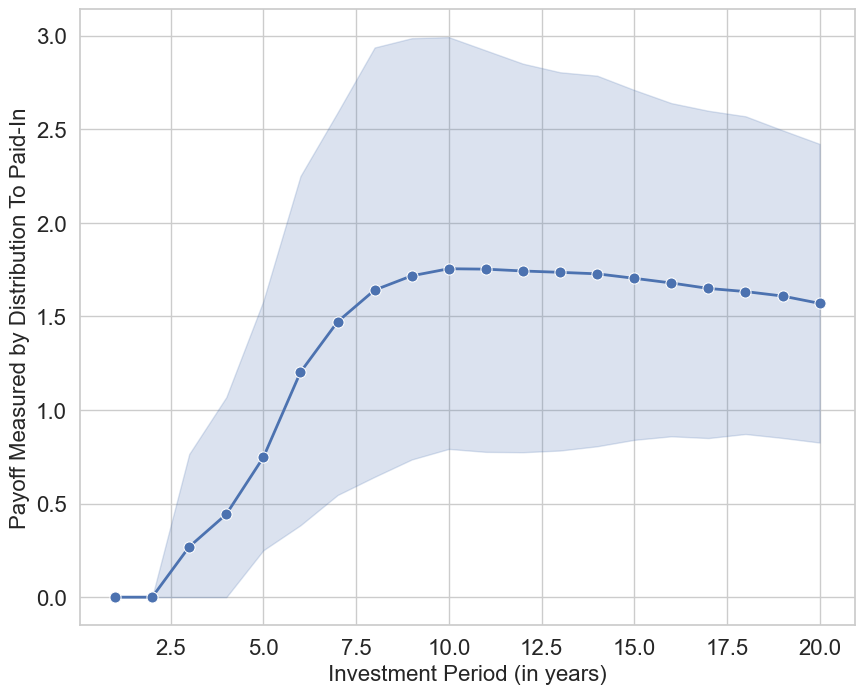

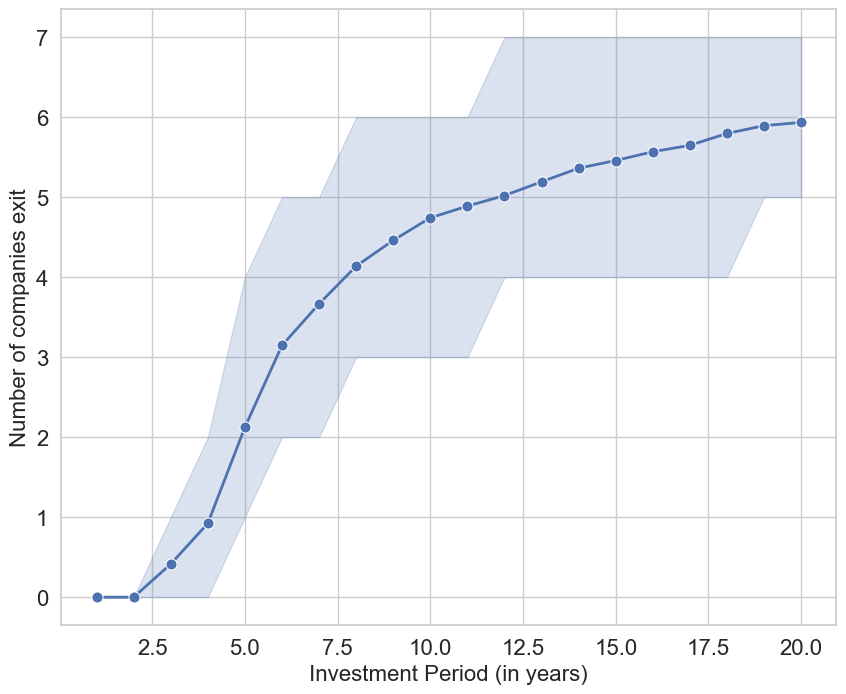

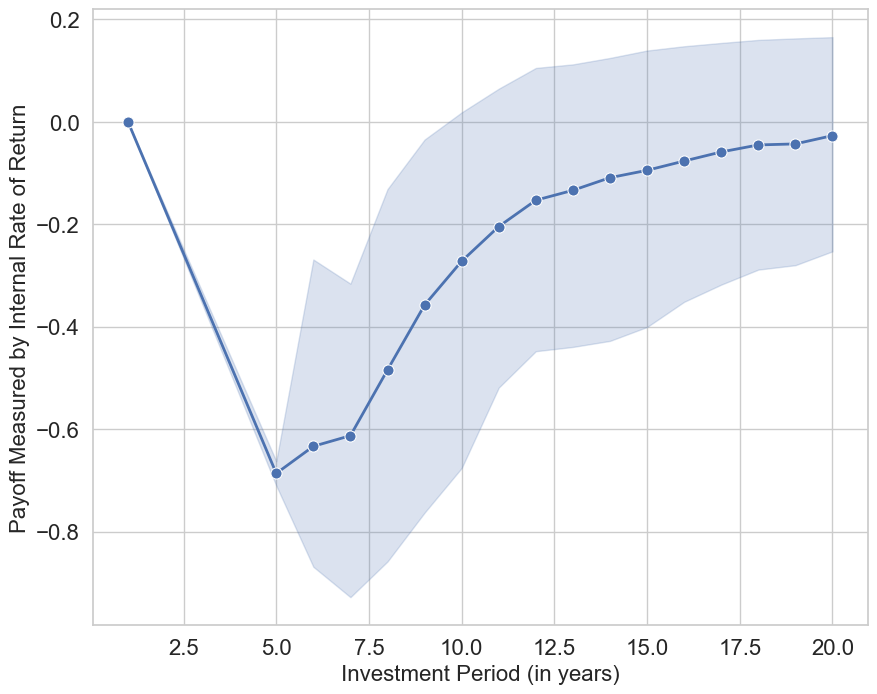

In [235]:
test_result_1.plot_result()


#### Different exit mutiples

In [239]:
# Assign values to DataFrames
def compare_exit_value(compare_value):
    
    metrics_name = ['Disturbution to Paid-in', 'Number of companies exit', 'Net Present Value']
    terminated_time = 20
    K_test = 500
    dfs = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(1, terminated_time + 1), K_test),
                        'Simulation label': np.tile(np.arange(K_test), terminated_time)})
    
    for muti in compare_value: 
        result_class = PE_portfolio_investperiod( K=K_test,I = 10, inital_firm_value = 40, invest_per_firmval= 0.2, Expact_exit_mutiple = muti,Max_investment_length= terminated_time,total_investment_amount=300,corr_true=False)
        DPI,number_company_exit, NAV, investment,irr = result_class.ARM_mini_investments_rounds()
        
        key = f'Disturbution to Paid-in when Single company exit multi = {muti}'
        dfs[key] = DPI.flatten()  
        
        key = f'Number of companies exit when Single company exit multi = {muti}'
        dfs[key] = number_company_exit.flatten()  
        
        key = f'Net Present Value when Single company exit multi = {muti}'
        dfs[key] = NAV.flatten()  
        
        key = f'Total investment amount when Single company exit multi = {muti}'
        dfs[key] = investment.flatten()  
        
        key = f'IRR when Single company exit multi = {muti}'
        dfs[key] = irr.flatten()  

    # Plotting
    sns.set(rc={'figure.figsize': (12, 8)})
    sns.set_style("whitegrid")
    
    # Define line styles and markers
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', 'D', '^']

    # Plot all metrics
    for metric in metrics_name:
        plt.figure()  # Create a new figure for each metric
        for idx, i in enumerate(compare_value):
            sns.lineplot(x='Investment Period (in years)',
                 y=f'{metric} when Single company exit multi = {i}',
                 data=dfs,
                 errorbar=("pi", 80),
                 label=f'Single company exit multi = {i}',
                 linewidth=2,
                 linestyle=line_styles[idx],
                 marker=markers[idx],
                 markersize=8)


        plt.xlabel("Investment Period (in years)", fontsize=16)
        plt.ylabel(f'{metric}', fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(fontsize=13)
        # plt.show()
        plt.savefig(f'figures_new/{metric} under different exit multi.jpg', dpi=400,format='jpeg')
        plt.close()  # Close the figure to avoid overlap
    return dfs

In [240]:
exit_multi = [6,12,20]
df_new_compn_exit_diff = compare_exit_value(exit_multi)

#### Wth correlation

In [241]:
# Assign values to DataFrames
metrics_name = ['Disturbution to Paid-in', 'Number of companies exit', 'Net Present Value']
terminated_time = 20
K_test = 500
dfs = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(1, terminated_time + 1), K_test),
                    'Simulation label': np.tile(np.arange(K_test), terminated_time)})

for i in [True,False]:
    result_class = PE_portfolio_investperiod(K=K_test, invest_per_firmval= 0.2, Expact_exit_mutiple = 12,  Max_investment_length= terminated_time,total_investment_amount=300,corr_true = i)
    DPI,number_company_exit, NAV, _,irr = result_class.ARM_mini_investments_rounds()
    
    key = f'Disturbution to Paid-in when considering correlation between portfolio = {i}'
    dfs[key] = DPI.flatten()  
    
    key = f'Number of companies exit when considering correlation between portfolio = {i}'
    dfs[key] = number_company_exit.flatten()  
    
    key = f'Net Present Value when considering correlation between portfolio = {i}'
    dfs[key] = NAV.flatten()  
    
    key = f'IRR when considering correlation between portfolio = {i}'
    dfs[key] = irr.flatten()  

# Plotting
sns.set(rc={'figure.figsize': (12, 8)})
sns.set_style("whitegrid")
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', 'D', '^']
# Plot all metrics
for metric in metrics_name:
    plt.figure()  # Create a new figure for each metric
    for idx, i in enumerate([True,False]):
        sns.lineplot(x='Investment Period (in years)',
                y=f'{metric} when considering correlation between portfolio = {i}',
                data=dfs,
                errorbar=("pi", 80),
                label=f'Correlation between portfolio = {i}',
                linewidth=2,
                linestyle=line_styles[idx],
                marker=markers[idx],
                markersize=8)

    plt.xlabel("Investment Period (in years)", fontsize=16)
    plt.ylabel(f'{metric}', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=14)
    # plt.show()
    plt.savefig(f'figures_new/{metric} under differ corr.jpg', dpi=400,format='jpeg')
    plt.close()  # Close the figure to avoid overlap

#### Different investment condition

In [244]:
# Assign values to DataFrames
def compare_invest_incre_condition(compare_value):
    
    metrics_name = ['Disturbution to Paid-in', 'Number of companies exit', 'Net Present Value']
    terminated_time = 20
    K_test = 500
    dfs = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(1, terminated_time + 1), K_test),
                        'Simulation label': np.tile(np.arange(K_test), terminated_time)})
    
    for muti in compare_value: 
        result_class = PE_portfolio_investperiod( K=K_test,I = 10, inital_firm_value = 40, invest_per_firmval= 0.2, Expact_exit_mutiple = 12, Max_investment_length= terminated_time,total_investment_amount=300,investment_condition = muti,corr_true=False)
        DPI,number_company_exit, NAV, investment,irr = result_class.ARM_mini_investments_rounds()
        
        key = f'Disturbution to Paid-in when investment condition on {muti} times firm value increment'
        dfs[key] = DPI.flatten()  
        
        key = f'Number of companies exit when investment condition on {muti} times firm value increment'
        dfs[key] = number_company_exit.flatten()  
        
        key = f'Net Present Value when investment condition on {muti} times firm value increment'
        dfs[key] = NAV.flatten()  
        
        # key = f'Total investment amount when Single company exit multi = {muti}'
        # dfs[key] = investment.flatten()  
        
        # key = f'IRR when Single company exit multi = {muti}'
        # dfs[key] = irr.flatten()  

    # Plotting
    sns.set(rc={'figure.figsize': (12, 8)})
    sns.set_style("whitegrid")
    
    # Define line styles and markers
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', 'D', '^']

    # Plot all metrics
    for metric in metrics_name:
        plt.figure()  # Create a new figure for each metric
        for idx, i in enumerate(compare_value):
            sns.lineplot(x='Investment Period (in years)',
                 y=f'{metric} when investment condition on {i} times firm value increment',
                 data=dfs,
                 errorbar=("pi", 80),
                 label=f'Investment condition on {i} times firm value increment',
                 linewidth=2,
                 linestyle=line_styles[idx],
                 marker=markers[idx],
                 markersize=8)


        plt.xlabel("Investment Period (in years)", fontsize=16)
        plt.ylabel(f'{metric}', fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(fontsize=13)
        # plt.show()
        plt.savefig(f'figures_new/{metric} under different invest conditions.jpg', dpi=400,format='jpeg')
        plt.close()  # Close the figure to avoid overlap
    return dfs

In [245]:
invest_cond = [1.0,1.5,2.0]
df_compare_inves_cond = compare_invest_incre_condition(invest_cond)

#### Under different total investment constriant

In [246]:
# Assign values to DataFrames
def compare_investment_amount(compare_value):
    
    metrics_name = ['Disturbution to Paid-in', 'Number of companies exit', 'Net Present Value','IRR']
    terminated_time = 20
    K_test = 100
    dfs = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(1, terminated_time + 1), K_test),
                        'Simulation label': np.tile(np.arange(K_test), terminated_time)})
    
    for invest in compare_value:
        result_class = PE_portfolio_investperiod(K=K_test, inital_firm_value = 40,invest_per_firmval= 0.2, Expact_exit_mutiple = 12,  Max_investment_length= terminated_time,total_investment_amount=invest)
        DPI,number_company_exit,NAV,_,irr = result_class.ARM_mini_investments_rounds()
        
        key = f'Disturbution to Paid-in when total investment amount = {invest}'
        dfs[key] = DPI.flatten()  
        
        key = f'Number of companies exit when total investment amount = {invest}'
        dfs[key] = number_company_exit.flatten()  
        
        key = f'Net Present Value when total investment amount = {invest}'
        dfs[key] = NAV.flatten()  
        
        key = f'IRR when total investment amount = {invest}'
        dfs[key] = irr.flatten()  

    # Plotting
    sns.set(rc={'figure.figsize': (12, 8)})
    sns.set_style("whitegrid")
    
    # Define line styles and markers
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', 'D', '^']

    # Plot all metrics
    for metric in metrics_name:
        plt.figure()
        for idx, i in enumerate(compare_value):
            sns.lineplot(x='Investment Period (in years)',
                 y= f'{metric} when total investment amount = {i}',
                 data=dfs,
                 errorbar=("pi", 80),
                 label= f'Total Investment Amount = {i}',
                 linewidth=2,
                 linestyle=line_styles[idx],
                 marker=markers[idx],
                 markersize=8)

        plt.xlabel("Investment Period (in years)", fontsize=16)
        plt.ylabel(f'{metric}', fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(fontsize=14)
        plt.savefig(f'figures_new/{metric} under total investment amount.jpg', dpi=400,format='jpeg')
        plt.close()  # Close the figure to avoid overlap
        
    return dfs

In [247]:
investment_amount = [100, 300, 500]
df_compare_investment_amount = compare_investment_amount(investment_amount)

## Model Validation

### some comments on the validation for one company

For one company validation we suppose:
1. mu, sigma, growth rate choosen based on data 
4. failure rate not included (as the data only include companies successfully exit)
2. The initial firm value, investment amount and date are all fixed as the actual data

### SIAM model for one comapny

In [76]:
# revised 10.28
class selection_one_company_knowndata():
    def __init__(self, K=100, growth_rate= 3, invest_jump = 1,decrease_jump = 0, investment_amount=[30,40,50], investment_round=[1,3,4], inital_firm_value=150, Max_investment_length= 20, Expacted_net_pro_ratio=10, muti=3):
        self.K = K #number of iteration
        self.growth_rate = growth_rate
        self.invest_jump = invest_jump
        self.decrease_jump = decrease_jump
        self.inital_firm_value = inital_firm_value
        self.investment_round = investment_round
        self.investment_amount = investment_amount
        self.Max_investment_length = Max_investment_length 
        self.Expacted_net_pro_ratio = Expacted_net_pro_ratio
        self.muti = muti 
    
    def fimevalue(self,s0):
        size= 12
        dt = 1/12 
        # r,sigma = 0.02, 0.5
        r,sigma = (0.03+ self.growth_rate)/size, 0.5/size
        geo = np.cumsum(((r -  sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)
        return np.exp(geo[-1])*s0
        

    # Model exit condition on exit mutiples + jump incre + jump decrease
    def Mini_investments_rounds_muti_JD1(self):
        
        # descision variable: Company's status in the portfolio --- 0 in 1 out
        company_invest_status = np.zeros((self.Max_investment_length,self.K))
        
        # firm value
        # firm_value = np.full((self.K,self.Max_investment_length),self.inital_firm_value)
        zero_positions = [i for i, x in enumerate(self.investment_round) if x == 0]

        jump_at_0 = sum(self.investment_amount[i] for i in zero_positions) if zero_positions else 0

        if jump_at_0 != 0:
            firm_value = np.full((self.K,self.Max_investment_length),self.inital_firm_value*np.exp(self.invest_jump*jump_at_0/self.inital_firm_value))
        else:
            firm_value = np.full((self.K,self.Max_investment_length),self.inital_firm_value)
        
        
        # investment amount at time t 
        sum_investment = np.zeros(self.Max_investment_length)
        np.put(sum_investment, self.investment_round, self.investment_amount)  # Assign values at specified indices
        sum_investment_list = np.cumsum(sum_investment)

        exit_time_list = np.zeros(self.K)

        for k in range(self.K): 
            # Number of rounds of investment companies go though 
            # company_rounds = 0
            if jump_at_0 != 0:
                company_rounds = len(zero_positions)
            else:
                company_rounds = 0

            for t in range(1,self.Max_investment_length):
                
                if firm_value[k][t-1] < self.inital_firm_value * 0.01:
                    company_invest_status[t:,k] = np.full((self.Max_investment_length-t),2)
                else:
                    # Check if company is still in portfolio
                    if company_invest_status[t][k] == 0:
                        
                        # firm value : last time +/- bad
                        # Last part: For companies go through bad sceniaro firm value decrease
                        firm_value[k][t] = self.fimevalue(firm_value[k][t-1]) * np.exp(np.random.poisson(0.2*t)*(self.decrease_jump))
                        
                        # Exit the company if reach threshold
                        if (company_rounds < len(self.investment_round) -1) & (t == self.investment_round[company_rounds]):
                            firm_value[k][t] = (firm_value[k][t] + self.investment_amount[company_rounds])*np.exp(self.invest_jump*self.investment_amount[company_rounds]/firm_value[k][t])
                            company_rounds = company_rounds + 1
                                    
                        # For company still in the portfolio and need investment
                        else:
                            if (sum_investment_list[t-1] > 0) and (firm_value[k][t]/self.inital_firm_value > self.muti):
                                company_invest_status[t][k] = 1
                                exit_time_list[k] = t
                                break        
                
                exit_time_list= np.where(exit_time_list==0, np.nan, exit_time_list)
        return exit_time_list,np.nanmean(exit_time_list)
    

In [77]:
company1 = selection_one_company_knowndata(K=100,growth_rate= 2,investment_amount=[10,20,40], investment_round=[0,0,4],invest_jump= 3, decrease_jump = 0, muti= 3)
# output whether the company was successfully exit + investment amount in each round + exit firm value at each round
company1.Mini_investments_rounds_muti_JD1()

(array([4., 4., 3., 4., 3., 4., 4., 4., 4., 3., 3., 5., 3., 3., 4., 3., 4.,
        3., 3., 3., 3., 4., 3., 3., 4., 4., 4., 4., 3., 3., 3., 3., 4., 4.,
        4., 3., 4., 3., 3., 4., 4., 4., 3., 4., 4., 3., 3., 4., 4., 3., 4.,
        3., 4., 3., 4., 3., 4., 4., 3., 3., 4., 3., 3., 4., 4., 4., 3., 3.,
        3., 3., 3., 3., 3., 4., 3., 4., 3., 3., 4., 4., 3., 3., 4., 3., 3.,
        4., 3., 4., 3., 3., 3., 4., 3., 3., 4., 3., 3., 3., 3., 3.]),
 3.45)

### Valdition --- fit growth rate and other factor's influence, compare with DeTree

In [78]:
df_delete_extreme.shape[0]

711

In [79]:
df_delete_extreme_val = df_delete_extreme.copy()

#### The bisection method to fit the growth rate for all companies

In [80]:
def find_growth_rate(df,invest_jump_rate):
    
    SIAM_cal_growth_rate = np.zeros((df.shape[0]))

    convert_float_to_int = lambda value: np.nan if np.isnan(value) else int(round(value))


    for index, row in df.iterrows():
        upper_bound = 20
        lower_bound = -20
        eplison = 0.01
        repeated_time = 50
        target_tau = row['Investment_period']
        contiu = True
        
        company_exit_round = selection_one_company_knowndata(K=repeated_time, invest_jump= invest_jump_rate, growth_rate=lower_bound, investment_amount = row['investment_amount_list'], investment_round =  row['investment_time_list'], 
                                                            inital_firm_value = row['initial_firmvalue'],
                                                            Max_investment_length = 20, Expacted_net_pro_ratio=row['payoff_DPI'],muti=row['payoff_firmvalue_muti'])
        _, tau = company_exit_round.Mini_investments_rounds_muti_JD1()
        tau = convert_float_to_int(tau)

        while tau != target_tau and ((upper_bound-lower_bound)>=eplison) and (contiu == True):

            guess_growthrate = (lower_bound + upper_bound) / 2
            company_exit_round = selection_one_company_knowndata(K=repeated_time, invest_jump= invest_jump_rate, growth_rate=guess_growthrate, investment_amount = row['investment_amount_list'], investment_round =  row['investment_time_list'], 
                                                            inital_firm_value = row['initial_firmvalue'],
                                                            Max_investment_length = 20, Expacted_net_pro_ratio=row['payoff_DPI'],muti=row['payoff_firmvalue_muti'])
            _, tau = company_exit_round.Mini_investments_rounds_muti_JD1()

            tau = convert_float_to_int(tau)

            if tau == target_tau:
                SIAM_cal_growth_rate[index] = guess_growthrate
                contiu = False
            else:
                if (tau > target_tau) or np.isnan(tau):
                    lower_bound = guess_growthrate
                else:
                    upper_bound = guess_growthrate
                    # print(guess_growthrate,tau,target_tau)
        if contiu:
            if (tau == target_tau -1) or (tau == target_tau + 1):
                SIAM_cal_growth_rate[index] = guess_growthrate
            SIAM_cal_growth_rate[index] = np.nan
        # else:
        #     SIAM_cal_growth_rate[index] = guess_growthrate
        
    df['SIAM_growth_rate_{}'.format(invest_jump_rate)] = SIAM_cal_growth_rate

    return df

#### Find Growth rate for all companies --- current only 340 avaliable

##### study why invest jump increase avability decrease

In [81]:
df_delete_extreme_val = find_growth_rate(df_delete_extreme_val,1.5)
df_delete_extreme_val = find_growth_rate(df_delete_extreme_val,1)
df_delete_extreme_val = find_growth_rate(df_delete_extreme_val,0.5)
df_delete_extreme_val = find_growth_rate(df_delete_extreme_val,0)

In [82]:
df_delete_extreme_val.iloc[:,20:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SIAM_growth_rate_1.5  344 non-null    float64
 1   SIAM_growth_rate_1    389 non-null    float64
 2   SIAM_growth_rate_0.5  453 non-null    float64
 3   SIAM_growth_rate_0    529 non-null    float64
dtypes: float64(4)
memory usage: 22.3 KB


<AxesSubplot: >

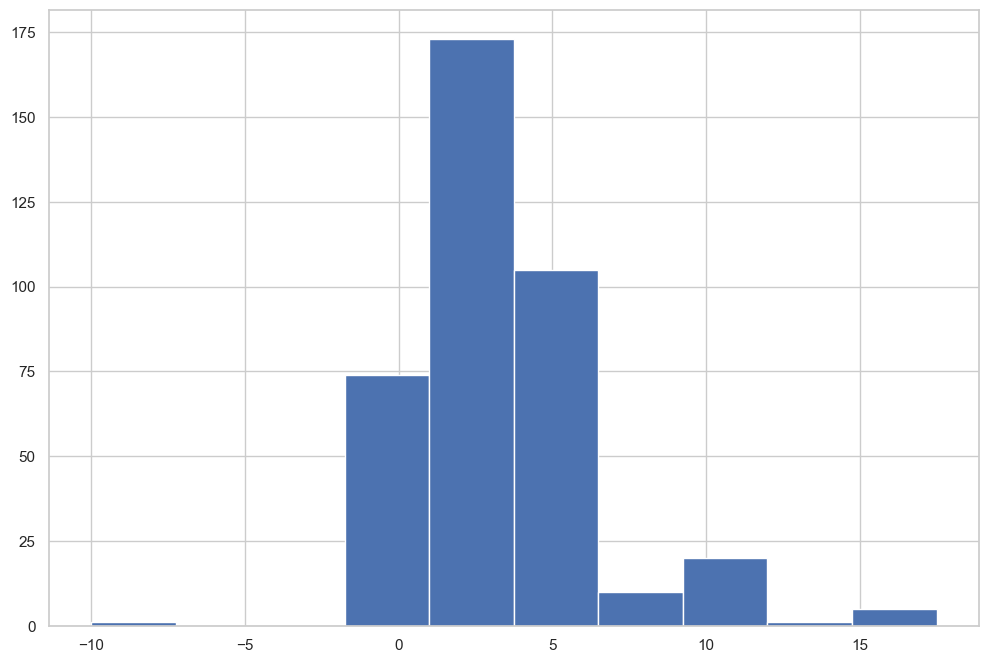

In [86]:
df_delete_extreme_val['SIAM_growth_rate_1'].hist()

Best fitting distribution: norm
Parameters: (3.2300369537275064, 2.875346476576205)
Kolmogorov-Smirnov statistic: 0.16860847406653268
P-value: 3.892104834449567e-10


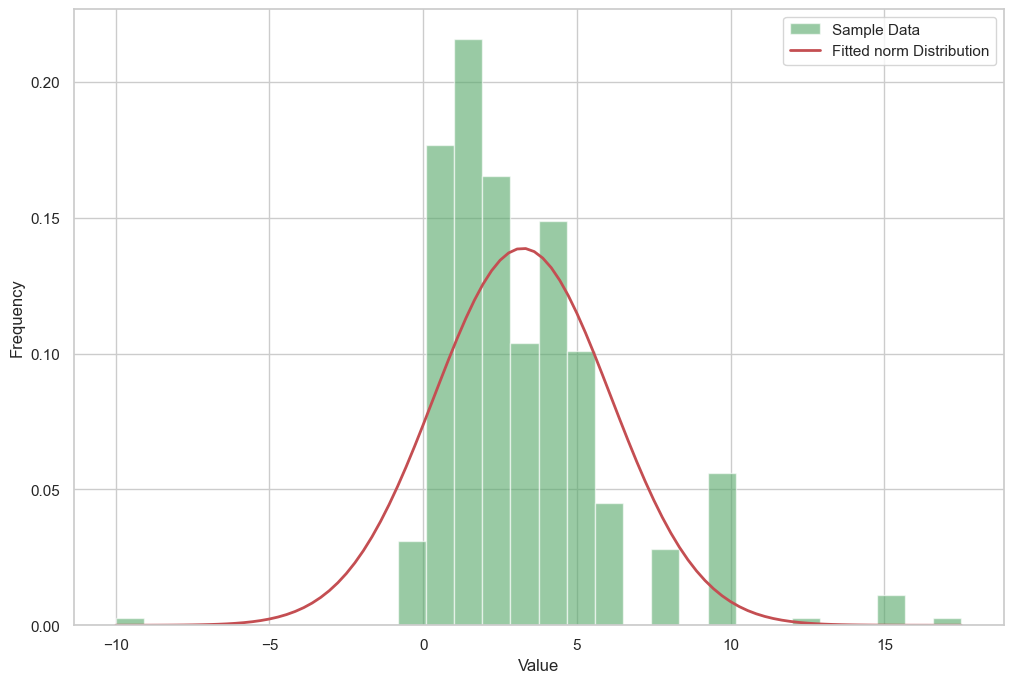

In [89]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Generate a sample data
sample = df_delete_extreme_val['SIAM_growth_rate_1'].dropna()

# List of distributions to test
distributions = ['norm'] # 'expon', 'beta', 'gamma', 'lognorm'

results = []
for distribution in distributions:
    dist = getattr(stats, distribution)
    params = dist.fit(sample)
    
    # Calculate goodness of fit using Kolmogorov-Smirnov test
    D, p = stats.kstest(sample, distribution, args=params)
    
    results.append((distribution, D, p, params))

# Select the best-fitting distribution
best_fit = min(results, key=lambda item: item[1])
best_distribution, best_D, best_p, best_params = best_fit
print(f"Best fitting distribution: {best_distribution}")
print(f"Parameters: {best_params}")
print(f"Kolmogorov-Smirnov statistic: {best_D}")
print(f"P-value: {best_p}")

# Generate a range of values
x = np.linspace(min(sample), max(sample), 100)

# Get the PDF of the fitted distribution
fitted_pdf = getattr(stats, best_distribution).pdf(x, *best_params)

# Plot the histogram of the sample and the fitted distribution
plt.hist(sample, bins=30, density=True, alpha=0.6, color='g', label='Sample Data')
plt.plot(x, fitted_pdf, 'r-', lw=2, label=f'Fitted {best_distribution} Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


##### Validation via Decision Tree Model 

In [276]:
def DecisTree_predict_RMSE(df,y_label):
    # return y_predict

    X_feature_column_name = ['initial_firmvalue','industry_encoded','start_date_diff_earliest','sum_invest_amount','Number_of_round','payoff_firmvalue_muti','exit_type']
    df_X = df[X_feature_column_name]
    df_Y = df[[y_label]].values
    df_Y_reshaped  = np.reshape(df_Y , (-1,1))

    # Standard 
    scaler = StandardScaler()
    df_X_scaler = scaler.fit_transform(df_X)

    regressor = DecisionTreeRegressor()

    # Define the hyperparameter grid for GridSearchCV
    params = {"max_depth": np.arange(1, 11)}

    # Create the GridSearchCV instance
    grid = GridSearchCV(regressor, params, scoring='neg_root_mean_squared_error', cv=5)

    # Fit the GridSearchCV on the training data
    grid.fit(df_X_scaler,df_Y_reshaped)

    # Get the best estimator from the grid search
    best_estimator = grid.best_estimator_

    # Print the test score
    # print('Best Estimator',best_estimator, ' Best Score',grid.best_score_,'for ',y_label)

    return best_estimator,grid.best_score_,df_X_scaler,df_Y_reshaped
        

The normal way euqation

In [269]:
def DTgrowthrate_SIAMinvestperiod_RMSE(df,investjump):

    best_est,_,df_X_scaler,df_Y_reshaped = DecisTree_predict_RMSE(df,'SIAM_growth_rate')
    
    regressor = DecisionTreeRegressor(max_depth=best_est.max_depth)
    df_Y_pred = cross_val_predict(regressor, df_X_scaler,df_Y_reshaped, cv=3)
    df['DT_pred_growthrate_{}'.format(0)] = df_Y_pred

    DT_SIAM_invest_period = []
    for index, row in df.iterrows():
        company1 = selection_one_company_knowndata(K=20,invest_jump = investjump, growth_rate=row['DT_pred_growthrate_{}'.format(0)],investment_amount = row['investment_amount_list'], investment_round =  row['investment_time_list'], inital_firm_value = row['initial_firmvalue'],
                                                                Max_investment_length = 20, Expacted_net_pro_ratio=row['payoff_DPI'],muti=row['payoff_firmvalue_muti'])
    # output whether the company was successfully exit + investment amount in each round + exit firm value at each round
        _,tau = company1.Mini_investments_rounds_muti_JD1()
        DT_SIAM_invest_period.append(tau)
    df['DT_SIAM_investperiod_{}'.format(investjump)] = DT_SIAM_invest_period
    df_dropna = df.dropna(axis=0)
    # r2_score(df_delete_extreme_val['DT_SIAM_investperiod'],df_delete_extreme_val['Investment_period'])
    return df, np.sqrt(mean_squared_error(df_dropna['DT_SIAM_investperiod_{}'.format(investjump)],df_dropna['Investment_period']))

The opposite way equation

In [270]:
def DTinvestperiod_SIAMgrowthrate_RMSE(df,invest_jump_rate):
    
    SIAM_cal_growth_rate = np.zeros((df.shape[0]))

    convert_float_to_int = lambda value: np.nan if np.isnan(value) else int(round(value))


    for index, row in df.iterrows():
        upper_bound = 20
        lower_bound = -20
        eplison = 0.01
        repeated_time = 50
        target_tau = row['DT_pred_investperiod_{}'.format(invest_jump_rate)] 
        contiu = True
        
        company_exit_round = selection_one_company_knowndata(K=repeated_time, invest_jump= invest_jump_rate, growth_rate=lower_bound, investment_amount = row['investment_amount_list'], investment_round =  row['investment_time_list'], 
                                                            inital_firm_value = row['initial_firmvalue'],
                                                            Max_investment_length = 20, Expacted_net_pro_ratio=row['payoff_DPI'],muti=row['payoff_firmvalue_muti'])
        _, tau = company_exit_round.Mini_investments_rounds_muti_JD1()
        tau = convert_float_to_int(tau)

        while tau != target_tau and ((upper_bound-lower_bound)>=eplison) and (contiu == True):

            if tau == (target_tau -1) or (tau == target_tau + 1):
                tau_close = True
            guess_growthrate = (lower_bound + upper_bound) / 2
            company_exit_round = selection_one_company_knowndata(K=repeated_time, invest_jump= invest_jump_rate, growth_rate=guess_growthrate, investment_amount = row['investment_amount_list'], investment_round =  row['investment_time_list'], 
                                                            inital_firm_value = row['initial_firmvalue'],
                                                            Max_investment_length = 20, Expacted_net_pro_ratio=row['payoff_DPI'],muti=row['payoff_firmvalue_muti'])
            _, tau = company_exit_round.Mini_investments_rounds_muti_JD1()

            tau = convert_float_to_int(tau)

            if tau == target_tau:
                SIAM_cal_growth_rate[index] = guess_growthrate
                contiu = False
            else:
                if (tau > target_tau) or np.isnan(tau):
                    lower_bound = guess_growthrate
                else:
                    upper_bound = guess_growthrate
                    # print(guess_growthrate,tau,target_tau)
        if contiu:
            if (tau == target_tau -1) or (tau == target_tau + 1):
                SIAM_cal_growth_rate[index] = guess_growthrate
            SIAM_cal_growth_rate[index] = np.nan
        # else:
        #     SIAM_cal_growth_rate[index] = guess_growthrate
        
    df['DTSIAM_growth_rate_{}'.format(invest_jump_rate)] = SIAM_cal_growth_rate

    df.dropna(axis = 0, inplace=True)

    return df,np.sqrt(mean_squared_error(df['DTSIAM_growth_rate_{}'.format(invest_jump_rate)],df['SIAM_growth_rate']))

The opposite way compare growth rate for different invest jump

In [277]:
for i in [0,0.5,1,1.5]:
    print('Invest jump: ',i)

    useful_columns = ['initial_firmvalue','Initial_investment_date','industry_encoded','start_date_diff_earliest','sum_invest_amount','Number_of_round','exit_type','payoff_firmvalue_muti','payoff_DPI','investment_time_list','investment_amount_list','SIAM_growth_rate_{}'.format(i),'Investment_period']
    df_delete_extreme_val_copy = df_delete_extreme_val[useful_columns].copy()
    df_delete_extreme_val_copy.dropna(axis = 0, inplace = True)
    df_delete_extreme_val_copy.index = range(len(df_delete_extreme_val_copy))
    df_delete_extreme_val_copy['SIAM_growth_rate'] = df_delete_extreme_val_copy['SIAM_growth_rate_{}'.format(i)]

    # DT for invest period SIAM for growth rate
    best_est,_,df_X_scaler,df_Y_reshaped = DecisTree_predict_RMSE(df_delete_extreme_val_copy,'Investment_period')
    regressor = DecisionTreeRegressor(max_depth=best_est.max_depth)
    df_Y_pred = cross_val_predict(regressor, df_X_scaler,df_Y_reshaped, cv=3)
    df_delete_extreme_val_copy['DT_pred_investperiod_{}'.format(i)] = df_Y_pred.astype(int)

    df_test_back, rmse_growthrate = DTinvestperiod_SIAMgrowthrate_RMSE(df_delete_extreme_val_copy,i)
    print('DT for investment period and SIAM for growth rate ',rmse_growthrate)

    # DT for growth rate
    best_est,best_rmse,df_X_scaler,df_Y_reshaped = DecisTree_predict_RMSE(df_test_back,'SIAM_growth_rate') # inbuilt print DT predict growth rate 
    print('DT for Growth rate std ', -best_rmse)

    print('Growth rate std ', df_test_back['SIAM_growth_rate'].std())
    print('Growth rate count ', df_test_back['SIAM_growth_rate'].count())


Invest jump:  0


KeyError: "['SIAM_growth_rate_0'] not in index"

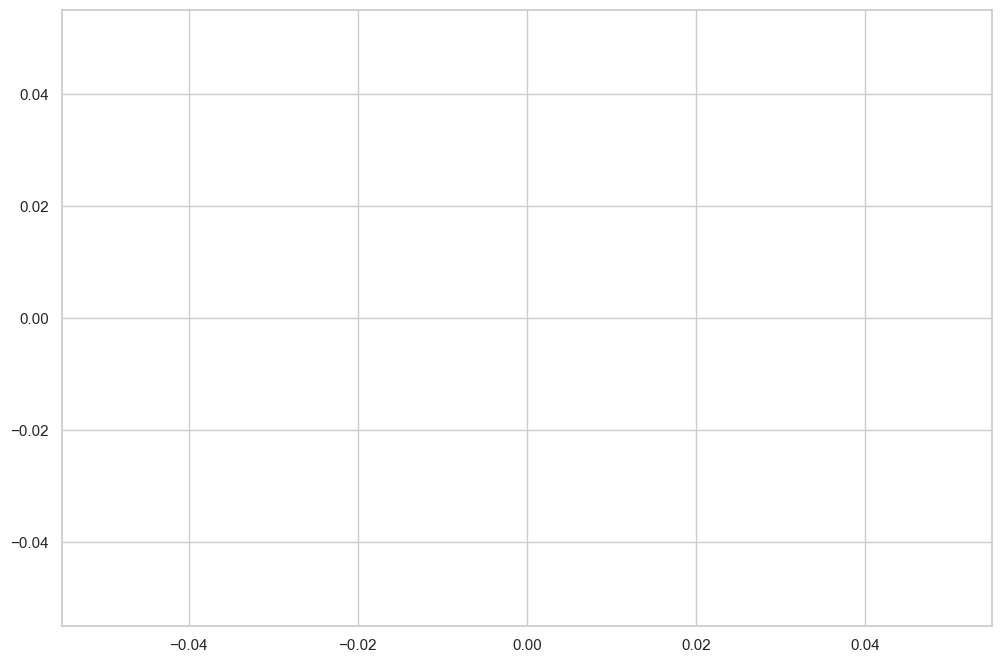

In [257]:
# Data
phi_2_values = [0, 0.5, 1, 1.5]
growth_rate_counts = [522, 444, 381, 327]

# Create a dataframe to use with seaborn

data = pd.DataFrame({'Increment Percentage (phi_2)': phi_2_values, 'Number of Growth Rates': growth_rate_counts})

# Create the bar plot using seaborn
plt.plot()
plt.figure(figsize=(12, 7))
sns.set_style('whitegrid')
ax = sns.lineplot(x='Increment Percentage (phi_2)', y='Number of Growth Rates', data=data, palette="Set2",marker ='o',markersize = 8)
# ax = sns.scatterplot(x='Increment Percentage (phi_2)', y='Number of Growth Rates', data=data, palette="Set2")

# Add labels and title
plt.xlabel('Increment Percentage $\phi_2$',fontsize=14)
plt.ylabel('Number of Growth Rates can be calculated $\in [-20,20]$',fontsize=14)
# plt.title('Number of Growth Rates for Different Increment Percentages')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures_new/invest_jump_growthrate_avali.jpg', format='JPEG', dpi=400)
plt.close()

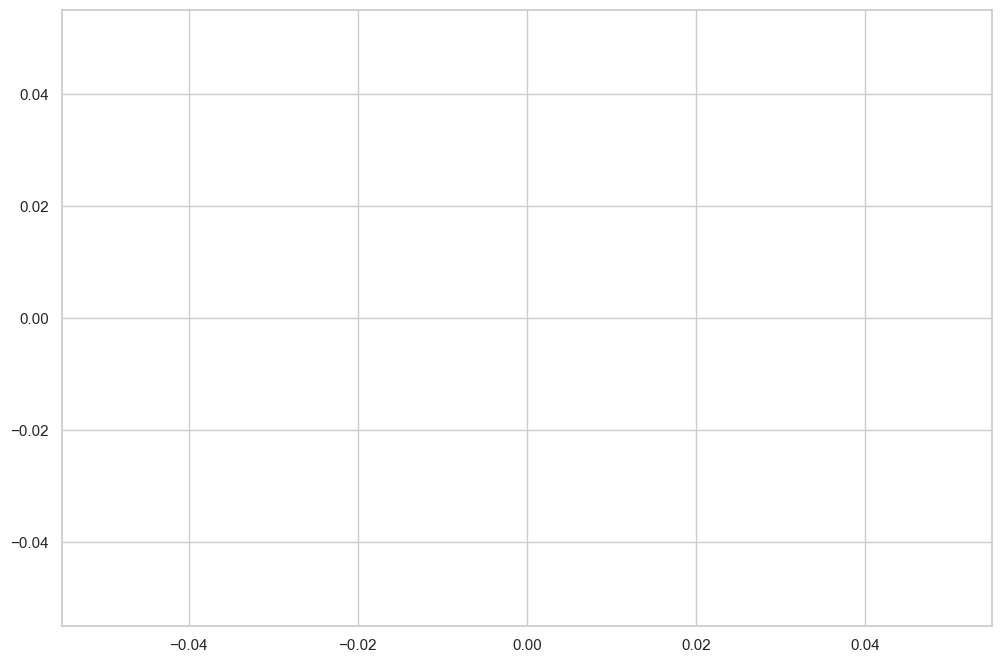

In [261]:
# Data
phi_2_values = [0, 0.5, 1, 1.5]
growth_rate_SIAM_RMSE = [2.712,2.780,2.618,2.473]
growth_rate_DescisionTree_RMSE = [2.623,2.874,2.745,2.660]
sns.set_style('whitegrid')
# Create a dataframe to use with seaborn
data = pd.DataFrame({
    'Increment Percentage (phi_2)': phi_2_values,
    'RMSE SIAM': growth_rate_SIAM_RMSE,
    'RMSE Decision Tree': growth_rate_DescisionTree_RMSE
})

# Create the bar plot using seaborn
plt.plot()
plt.figure(figsize=(10, 7))
ax = sns.lineplot(x='Increment Percentage (phi_2)', y='RMSE SIAM', data=data, label='RMSE SIAM',palette="Set2",marker ='D',markersize = 8)
ax = sns.lineplot(x='Increment Percentage (phi_2)', y='RMSE Decision Tree', data=data,label='RMSE Decision Tree', palette="Set2",marker ='o',markersize = 8)
# Add labels and title
plt.xlabel('Increment Percentage $\phi_2$',fontsize=14)
plt.ylabel('RMSE',fontsize=14)
# plt.title('Number of Growth Rates for Different Increment Percentages')
# Show the plot
plt.legend()
# Add labels and title
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures_new/invest_jump_growthrate_rmse.jpg', format='JPEG', dpi=400)
plt.close()


#### Compare back and normal method for validation

In [271]:
df_delete_extreme_val = find_growth_rate(df_delete_extreme_val,1)

In [273]:
df_delete_extreme_val.describe()

,initial_firmvalue,firmvalue_first_increment,firmvalue_final_increment,investment_increment_average,sum_invest_amount,Number_of_round,Investment_period,exit_value,exit_type,payoff_DPI,payoff_firmvalue_muti,start_date_diff_earliest,industry_encoded,investment_time_diff,SIAM_growth_rate_1
count,711.000000,711.000000,710.000000,711.000000,711.00000,711.000000,711.000000,710.000000,711.000000,710.000000,710.000000,711.000000,711.000000,711.000000,385.000000
mean,91.069030,140.432321,589.057417,20.378018,174.53692,4.011252,8.175809,1349.879332,0.668073,8.531082,19.798433,6.867692,49.430380,1.650055,3.268491
std,259.423536,804.481127,3460.263711,101.259496,670.37266,1.328936,3.636479,5363.984449,0.471236,24.741275,45.183818,3.778231,30.967414,0.745125,2.879130
min,1.070000,-473.990000,-12760.000000,-58.933333,0.73000,3.000000,1.000000,0.654000,0.000000,0.009972,0.100209,0.000000,0.000000,0.250000,-10.000000
25%,17.700000,8.505000,-49.120500,-0.032500,32.68000,3.000000,5.000000,60.000000,0.000000,1.322121,1.934046,3.876712,19.000000,1.000000,1.250000
50%,39.800000,29.370000,28.793000,5.490000,75.00000,4.000000,8.000000,206.010000,1.000000,3.369532,5.555016,6.972603,43.000000,1.500000,2.500000
75%,82.875000,86.130000,267.745000,16.812500,136.12500,5.000000,10.000000,727.522500,1.000000,7.699015,17.085627,9.841096,76.000000,2.000000,4.375000
max,3784.000000,13553.600000,49880.000000,2401.133333,11588.72000,12.000000,20.000000,67613.490000,1.000000,434.064081,481.839080,14.917808,103.000000,5.000000,17.500000


In [274]:
useful_columns = ['initial_firmvalue','Initial_investment_date','industry_encoded','start_date_diff_earliest','sum_invest_amount','Number_of_round','exit_type','payoff_firmvalue_muti','payoff_DPI','investment_time_list','investment_amount_list','SIAM_growth_rate_1','Investment_period']

df_delete_extreme_val_1 = df_delete_extreme_val[df_delete_extreme_val['Investment_period'] <= 15][useful_columns].copy()
df_delete_extreme_val_1.dropna(axis = 0, inplace = True)
df_delete_extreme_val_1.index = range(len(df_delete_extreme_val_1))
df_delete_extreme_val_1['SIAM_growth_rate'] = df_delete_extreme_val_1['SIAM_growth_rate_1']


In [278]:
df_test_nor,rmse_invest_siamdt = DTgrowthrate_SIAMinvestperiod_RMSE(df_delete_extreme_val_1,1)
rmse_invest_siamdt

3.6369040057968776

In [279]:
_, rmse_dt_invest, _, _ = DecisTree_predict_RMSE(df_test_nor,'Investment_period')
-rmse_dt_invest

2.8434039036346297

In [280]:
# Define a range of years you're interested in (2002 to 2016 in this case)
start_year = 2010
end_year = 2016
actual_max_period = []
pred_max_period = []

# Create a dictionary of DataFrames, each for a specific year
data_by_year = {}
for year in range(start_year, end_year + 1):
    df = df_test_nor[df_test_nor['Initial_investment_date'].dt.year == year]
    actual_max_period.append(df[['Investment_period']].max().values[0])
    pred_max_period.append(df[['DT_SIAM_investperiod_1']].max().values[0])
    

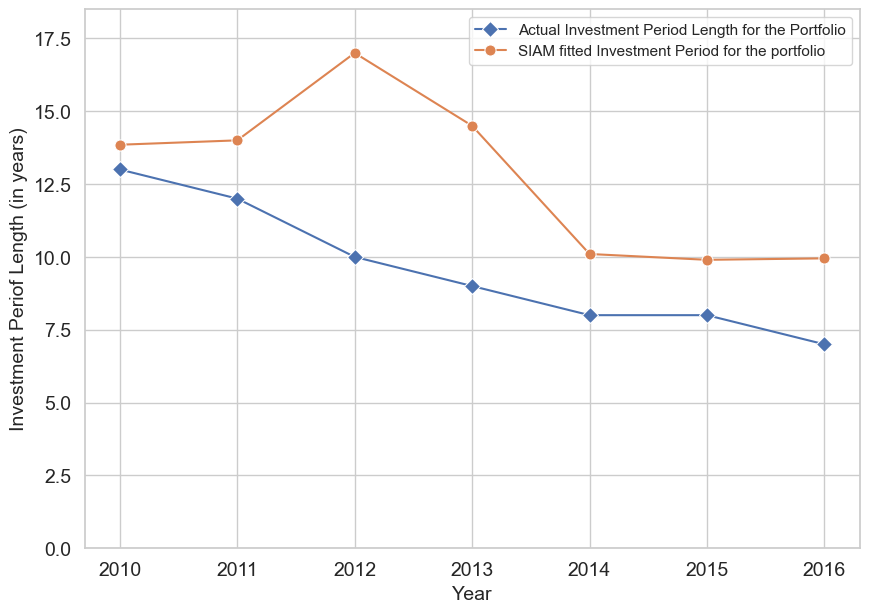

In [282]:
# Data
time_year = np.arange(2010, 2017)

sns.set_style('whitegrid')
# Create a dataframe to use with seaborn
data = pd.DataFrame({
    'Year': time_year,
    'Actual Investment Period (in years)': actual_max_period,
    'SIAM fitted Investment Period (in years)': pred_max_period
})

# Create the bar plot using seaborn
plt.figure(figsize=(10, 7))
ax = sns.lineplot(x='Year', y='Actual Investment Period (in years)', data=data, label='Actual Investment Period Length for the Portfolio',palette="Set2",marker ='D',markersize = 8)
ax = sns.lineplot(x='Year', y='SIAM fitted Investment Period (in years)', data=data,label='SIAM fitted Investment Period for the portfolio', palette="Set2",marker ='o',markersize = 8)

# Add labels and title
plt.xlabel('Year',fontsize=14)
plt.ylabel('Investment Periof Length (in years)',fontsize=14)
plt.ylim([0,18.5])
# Show the plot
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures_new/portfolio_compare_actual_inevstment_period.jpg', format='JPEG', dpi=400)